# CS440/ECE448 Spring 2023
# MP11: Reinforcement Learning

The first thing you need to do is to download this file: <a href="mp11.zip">mp11.zip</a>.  If you want, you can also download <a href="mp11_extra.zip">mp11_extra.zip</a>, the extra credit assignment.  `mp11.zip` has the following content:

* `submitted.py`: Your homework. Edit, and then submit to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.
* `mp11_notebook.ipynb`: This is a <a href="https://anaconda.org/anaconda/jupyter">Jupyter</a> notebook to help you debug.  You can completely ignore it if you want, although you might find that it gives you useful instructions.
* `pong.py`: This is a program that plays Pong.  If called interactively, it will call the module `pong_display.py` to create a display, so that you can play.  If told to use a Q-learner, it will call your `submitted.py` to do Q-learning.
* `grade.py`: Once your homework seems to be working, you can test it by typing `python grade.py`, which will run the tests in `tests/tests_visible.py`.
* `tests/test_visible.py`: This file contains about half of the <a href="https://docs.python.org/3/library/unittest.html">unit tests</a> that Gradescope will run in order to grade your homework.  If you can get a perfect score on these tests, then you should also get a perfect score on the additional hidden tests that Gradescope uses.
* `requirements.txt`: This tells you which python packages you need to have installed, in order to run `grade.py`.  You can install all of those packages by typing `pip install -r requirements.txt` or `pip3 install -r requirements.txt`.

This file (`mp11_notebook.ipynb`) will walk you through the whole MP, giving you instructions and debugging tips as you go.

### Table of Contents

1. <a href="#section1">Playing Pong</a>
1. <a href="#section2">Creating a Q-Learner Object</a>
1. <a href="#section3">Epsilon-First Exploration</a>
1. <a href="#section4">Q-Learning</a>
1. <a href="#section5">Saving and Loading Your Q and N Tables</a>
1. <a href="#section6">Exploitation</a>
1. <a href="#section7">Acting</a>
1. <a href="#section8">Training</a>
1. <a href="#section9">Extra Credit</a>
1. <a href="#grade">Grade Your Homework</a>

<a id='section1'></a>

## Playing Pong

Pong was the <a href="https://en.wikipedia.org/wiki/Pong">first video game produced by Atari.</a>  It is a simple game, based on table tennis.  Here is a two-person version of the game: https://commons.wikimedia.org/wiki/File:Pong_Game_Test2.gif

We will be playing a one-person version of the game:

* When the ball hits the top, bottom, or left wall of the playing field, it bounces.
* The right end of the playing field is open, except for the paddle.  If the ball hits the paddle, it bounces, and the player's score increments by one.  If the ball hits the open space, the game is over; the score resets to zero, and a new game begins.

The game is pretty simple, but in order to get a better feeling for it, you may want to try playing it yourself.  Use the up arrow to move the paddle upward, and the down arrow to move the paddle downward.  See how high you can make your score:


In [2]:
!python pong.py

pygame 2.1.3 (SDL 2.0.22, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html
Completed 0 games, 3 rewards, 416 frames, score 2, max score 2
Completed 1 games, 5 rewards, 821 frames, score 1, max score 2
Completed 2 games, 7 rewards, 1483 frames, score 1, max score 2
Completed 3 games, 8 rewards, 1737 frames, score 0, max score 2
Completed 4 games, 18 rewards, 3385 frames, score 9, max score 9
Completed 5 games, 19 rewards, 3566 frames, score 0, max score 9


Once you figure out how to use the arrow keys to control your paddle, we hope you will find that the game is not too hard for a human to play.  However, for a computer, it's difficult to know: where should the paddle be moved at each time step?  In order to see how difficult it is for a computer to play, let's ask the "random" player to play the game.

**WARNING:** The following line will open a pygame window.  The pygame window will be hidden by this window -- in order to see it, you will need to minimize this window.  The pygame window will consume a lot of CPU time just waiting for the processor, so in order to kill it, you will need to come back to this window, click on the block below, then click the Jupyter "stop" button (the square button at the top of this window) in order to stop processing.

In [1]:
!python pong.py --player random

<a id='section2'></a>

## Creating a Q-Learner Object

The first thing you will do is to create a `q_learner` object that can store your learned Q table and your N table (table of exploration counts).  

Like any other object-oriented language, python permits you to create new object classes in order to store data that will be needed from time to time.  If you are not already very, very familiar with python classes, you might want to study the python class tutorial: https://docs.python.org/3/tutorial/classes.html

Like any other object in python, a `q_learner` object is created by calling its name as a function, e.g., `my_q_learner=submitted.q_learner()`.  Doing so calls the function `submitted.q_learner.__init__()`.  Let's look at the docstring to see what it should do.

In [1]:
import submitted, importlib
importlib.reload(submitted)
help(submitted.q_learner.__init__)

Help on function __init__ in module submitted:

__init__(self, alpha, epsilon, gamma, nfirst, state_cardinality)
    Create a new q_learner object.
    Your q_learner object should store the provided values of alpha,
    epsilon, gamma, and nfirst.
    It should also create a Q table and an N table.
    Q[...state..., ...action...] = expected utility of state/action pair.
    N[...state..., ...action...] = # times state/action has been explored.
    Both are initialized to all zeros.
    Up to you: how will you encode the state and action in order to
    define these two lookup tables?  The state will be a list of 5 integers,
    such that 0 <= state[i] < state_cardinality[i] for 0 <= i < 5.
    The action will be either -1, 0, or 1.
    It is up to you to decide how to convert an input state and action
    into indices that you can use to access your stored Q and N tables.
    
    @params:
    alpha (scalar) - learning rate of the Q-learner
    epsilon (scalar) - probability of takin

Write your `__init__` function to meet the requirements specified in the docstring.  Once you have completed it, the following code should run without errors:

In [2]:
importlib.reload(submitted)

q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])

print(q_learner)


<a id='section3'></a>

## Epsilon-First Exploration

In order to manage the exploration/exploitation tradeoff, we will be using both "epsilon-first" and "epsilon-greedy" (https://en.wikipedia.org/wiki/Multi-armed_bandit#Semi-uniform_strategies).  

The epsilon-first strategy explores every state/action pair at least `nfirst` times before it ever starts to exploit any strategy.  Your `q_learner` should have a table to keep track of how many times it has explored a state/action pair prior to the start of any exploitation.  The method for storing that table is up to you; in order to have some standardized API, therefore, you need to write a method called `report_exploration_counts` that returns a list of the three exploration counts for a given state. 

In [8]:
importlib.reload(submitted)
help(submitted.q_learner.report_exploration_counts)

Help on function report_exploration_counts in module submitted:

report_exploration_counts(self, state)
    Check to see how many times each action has been explored in this state.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    explored_count (array of 3 ints): 
      number of times that each action has been explored from this state.
      The mapping from actions to integers is up to you, but there must be three of them.



Write `report_exploration_counts` so that it returns a list or array for any given state.  Test your code with the following:

In [9]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('This is how many times state [0,0,0,0,0] has been explored so far:')
print(q_learner.report_exploration_counts([0,0,0,0,0]))
print('This is how many times state [9,9,1,1,9] has been explored so far:')
print(q_learner.report_exploration_counts([9,9,1,1,9]))

This is how many times state [0,0,0,0,0] has been explored so far:
[0, 0, 0]
This is how many times state [9,9,1,1,9] has been explored so far:
[0, 0, 0]


When your learner first starts learning, it will call the function `choose_unexplored_action` to choose an unexplored action.  This function should choose a function uniformly at random from the set of unexplored actions in a given state, if there are any:

In [10]:
importlib.reload(submitted)
help(submitted.q_learner.choose_unexplored_action)

Help on function choose_unexplored_action in module submitted:

choose_unexplored_action(self, state)
    Choose an action that has been explored less than nfirst times.
    If many actions are underexplored, you should choose uniformly
    from among those actions; don't just choose the first one all
    the time.
    
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
       These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    action (scalar): either -1, or 0, or 1, or None
      If all actions have been explored at least n_explore times, return None.
      Otherwise, choose one uniformly at random from those w/count less than n_explore.
      When you choose an action, you should increment its count in your counter table.



If this has been written correctly, the following block should generate a random sequence of actions.  If the next block produces the same action 5 times in a row, that is the wrong result, and the result would be that your code does not pass the autograder.

In [36]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))


Next action: 0
Next action: 0
Next action: -1
Next action: 0
Next action: 1


After all three actions have been explored `nfirst` times, the function `choose_unexplored_action` should return `None`, as shown here:

In [38]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,1,[10,10,2,2,10])
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))


Next action: 1
Next action: 0
Next action: -1
Next action: None


<a id='section4'></a>

## Q-Learning

The reinforcement learning we are implementing is called Q-learning (https://en.wikipedia.org/wiki/Q-learning).  

Q-learning keeps a table $Q[s,a]$ that specifies the expected utility of action $a$ in state $s$.  The organization of this table is up to you.  In order to have a standard API, the first thing you should implement is a function `report_q` with the following docstring:

In [20]:
importlib.reload(submitted)
help(submitted.q_learner.report_q)

Help on function report_q in module submitted:

report_q(self, state)
    Report the current Q values for the given state.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    Q (array of 3 floats): 
      reward plus expected future utility of each of the three actions. 
      The mapping from actions to integers is up to you, but there must be three of them.



When your `q_learner` is first initialized, the value of $Q[state,action]$ should be zero for all state/action pairs, thus the `report_q` function should return lists of zeros:

In [39]:
importlib.reload(submitted)
q_learner=submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Q[0,0,0,0,0] is now:',q_learner.report_q([0,0,0,0,0]))
print('Q[9,9,1,1,9] is now:',q_learner.report_q([9,9,1,1,9]))

Q[0,0,0,0,0] is now: [0, 0, 0]
Q[9,9,1,1,9] is now: [0, 0, 0]


There are actually many different Q-learning algorithms available, but when people refer to Q-learning with no modifier, they usually mean the time-difference (TD) algorithm.  For example, this is the algorithm that's described on the wikipedia page (https://en.wikipedia.org/wiki/Q-learning).  This is the algorithm you will implement for this MP.

In supervised machine learning, the learner tries to imitate a reference label.  In reinforcement learning, there is no reference label.  Q-learning replaces the reference label with a "local Q" value, which is the utility that was obtained by performing action $a$ in state $s$ one time.  It is usually calculated like this:

$$Q_{local}(s_t,a_t) = r_t + \gamma\max_{a_{t+1}}Q(s_{t+1},a_{t+1})$$

where $r_t$ is the reward that was achieved by performing action $a_t$ in state $s_t$, $s_{t+1}$ is the state into which the game transitioned, and $a_{t+1}$ is one of the actions that could be performed in that state.  $Q_{local}$ is computed by your `q_local` function, which has this docstring:  

In [22]:
importlib.reload(submitted)
help(submitted.q_learner.q_local)

Help on function q_local in module submitted:

q_local(self, reward, newstate)
    The update to Q estimated from a single step of game play:
    reward plus gamma times the max of Q[newstate, ...].
    
    @param:
    reward (scalar float): the reward achieved from the current step of game play.
    newstate (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    Q_local (scalar float): the local value of Q



Initially, `q_local` should just return the given reward, because initially, all Q values are 0:

In [40]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,10,10])
print('Q_local(6.25,[9,9,1,1,9]) is currently:',q_learner.q_local(6.25,[9,9,1,1,9]))

Q_local(6.25,[9,9,1,1,9]) is currently: 6.25


Now you can use `q_learner.q_local` as the target for `q_learner.learn`.  The basic algorithm is

$$Q(s,a) = Q(s,a) + \alpha (Q_{local}(s,a)-Q(s,a))$$

Here is the docstring:

In [25]:
importlib.reload(submitted)
help(submitted.q_learner.learn)

Help on function learn in module submitted:

learn(self, state, action, reward, newstate)
    Update the internal Q-table on the basis of an observed
    state, action, reward, newstate sequence.
    
    @params:
    state: a list of 5 numbers: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle.
    action: an integer, one of -1, 0, or +1
    reward: a reward; positive for hitting the ball, negative for losing a game
    newstate: a list of 5 numbers, in the same format as state
    
    @return:
    None



The following block checks a sequence of Q updates:

1. First, $Q([9,9,1,1,9],-1)$ is updated.  Since all Q values start at zero, it will be updated to just have a value equal to $\alpha$ (0.05) times the given reward (6.25) for a total value of 0.3125.
1. When we print out $Q([9,9,1,1,9],:)$, we see that one of the elements has been updated.
1. Next, update $Q([9,9,1,1,8],1)$ with a given reward, and with $[9,9,1,1,9]$ as the given next state.  Since $Q([9,9,1,1,9],-1)$ is larger than zero, the next-state Q-value should be multiplied by $\gamma$ (0.99) and added to the reward (3.1), then multiplied by $\alpha$, giving a total value of 0.17046875.
1. The resulting Q-value is reported.

In [35]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
q_learner.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('Q[9,9,1,1,9] is now',q_learner.report_q([9,9,1,1,9]))
q_learner.learn([9,9,1,1,8],1,3.1,[9,9,1,1,9])
print('Q[9,9,1,1,8] is now',q_learner.report_q([9,9,1,1,8]))

Q[9,9,1,1,9] is now [0.3125, 0, 0]
Q[9,9,1,1,8] is now [0, 0, 0.17046875000000003]


<a id='section5'></a>

## Saving and Loading your Q and N Tables

After you've spent a long time training your `q_learner`, you will want to save your Q and N tables so that you can reload them later.  The format of Q and N is up to you, therefore it's also up to you to write the `save` and `load` functions.  Here are the docstrings:

In [42]:
importlib.reload(submitted)
help(submitted.q_learner.save)

Help on function save in module submitted:

save(self, filename)
    Save your Q and N tables to a file.
    This can save in any format you like, as long as your "load" 
    function uses the same file format.  We recommend numpy.savez,
    but you can use something else if you prefer.
    
    @params:
    filename (str) - filename to which it should be saved
    @return:
    None



In [43]:
importlib.reload(submitted)
help(submitted.q_learner.load)

Help on function load in module submitted:

load(self, filename)
    Load the Q and N tables from a file.
    This should load from whatever file format your save function
    used.  We recommend numpy.load, but you can use something
    else if you prefer.
    
    @params:
    filename (str) - filename from which it should be loaded
    @return:
    None



These functions can be tested by doing one step of training one `q_learner`, then saving its results, then loading them into another `q_learner`:

In [45]:
importlib.reload(submitted)
q_learner1 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Next action:',q_learner1.choose_unexplored_action([9,9,1,1,9]))
q_learner1.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('N1[9,9,1,1,8] is now',q_learner1.report_exploration_counts([9,9,1,1,9]))
print('Q1[9,9,1,1,8] is now',q_learner1.report_q([9,9,1,1,9]))
q_learner1.save('test.npz')

q_learner2 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('N2[9,9,1,1,8] starts out as',q_learner2.report_exploration_counts([9,9,1,1,9]))
print('Q2[9,9,1,1,8] starts out as',q_learner2.report_q([9,9,1,1,9]))
q_learner2.load('test.npz')
print('N2[9,9,1,1,8] is now',q_learner2.report_exploration_counts([9,9,1,1,9]))
print('Q2[9,9,1,1,8] is now',q_learner2.report_q([9,9,1,1,9]))


Next action: 1
N1[9,9,1,1,8] is now [0, 0, 1]
Q1[9,9,1,1,8] is now [0.3125, 0, 0]
N2[9,9,1,1,8] starts out as [0, 0, 0]
Q2[9,9,1,1,8] starts out as [0, 0, 0]
N2[9,9,1,1,8] is now [0, 0, 1]
Q2[9,9,1,1,8] is now [0.3125, 0.0, 0.0]


<a id='section6'></a>

## Exploitation

A reinforcement learner always has to trade off between exploration (choosing an action at random) versus exploitation (choosing the action with the maximum expected utility).  Before we worry about that tradeoff, though, let's first make sure that exploitation works.

In [46]:
importlib.reload(submitted)
help(submitted.q_learner.exploit)

Help on function exploit in module submitted:

exploit(self, state)
    Return the action that has the highest Q-value for the current state, and its Q-value.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    action (scalar int): either -1, or 0, or 1.
      The action that has the highest Q-value.  Ties can be broken any way you want.
    Q (scalar float): 
      The Q-value of the selected action



In [48]:
importlib.reload(submitted)
q_learner1 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
q_learner1.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('Q1[9,9,1,1,9] is now',q_learner1.report_q([9,9,1,1,9]))
print('The best action and Q from state [9,9,1,1,9] are',q_learner1.exploit([9,9,1,1,9]))

Q1[9,9,1,1,9] is now [0.3125, 0, 0]
The best action and Q from state [9,9,1,1,9] are (-1, 0.3125)


<a id='section7'></a>

## Acting

When your learner decides which action to perform, it should trade off exploration vs. exploitation using both the epsilon-first and the epsilon-greedy strategies:
1. If there is any action that has been explored fewer than `nfirst` times, then choose one of those actions at random.  Otherwise...
1. With probability `epsilon`, choose an action at random.  Otherwise...
1. Exploit.


In [49]:
importlib.reload(submitted)
help(submitted.q_learner.act)

Help on function act in module submitted:

act(self, state)
    Decide what action to take in the current state.
    If any action has been taken less than nfirst times, then choose one of those
    actions, uniformly at random.
    Otherwise, with probability epsilon, choose an action uniformly at random.
    Otherwise, choose the action with the best Q(state,action).
    
    @params: 
    state: a list of 5 integers: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    -1 if the paddle should move upward
    0 if the paddle should be stationary
    1 if the paddle should move downward



In order to test all three types of action (epsilon-first exploration, epsilon-greedy exploration, and exploitation), let's create a learner with `nfirst=1` and `epsilon=0.25`, and set it so that the best action from state `[9,9,1,1,9]` is `-1`.  With these settings, a sequence of calls to `q_learner.act` should produce the following sequence of actions:

1. The first three actions should include each possible action once.
1. After the first three actions, 3/4 of the remaining actions should be `-1`.  The remaining 1/4 should be randomly chosen.

In [62]:
importlib.reload(submitted)
q_learner=submitted.q_learner(0.05,0.25,0.99,1,[10,10,2,2,10])
q_learner.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('exploration_counts',q_learner.report_exploration_counts([9,9,1,1,9]))
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('exploration_counts',q_learner.report_exploration_counts([9,9,1,1,9]))
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('exploration_counts',q_learner.report_exploration_counts([9,9,1,1,9]))
print('Q[9,9,1,1,9] is now',q_learner.report_q([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))

An epsilon-first action: 1
exploration_counts [0, 0, 1]
An epsilon-first action: -1
exploration_counts [1, 0, 1]
An epsilon-first action: 0
exploration_counts [1, 1, 1]
Q[9,9,1,1,9] is now [0.3125, 0, 0]
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: 0
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: 1
An epsilon-greedy explore/exploit action: 1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: 1
An epsilon-greedy explore/exploit action: 0
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1


<a id='section8'></a>

## Training

Now that all of your components work, you can try training your algorithm.  Do this by giving your `q_learner` as a player to a new `pong.PongGame` object.  Set `visibility=False` so that the `PongGame` doesn't create a new window.

In [3]:
import pong, importlib, submitted
importlib.reload(pong)
help(pong.PongGame.__init__)

Help on function __init__ in module pong:

__init__(self, ball_speed=4, paddle_speed=8, learner=None, visible=True, state_quantization=[10, 10, 2, 2, 10])
    Create a new pong game, with a specified player.
    
    @params:
    ball_speed (scalar int) - average ball speed in pixels/frame
    paddle_speed (scalar int) - paddle moves 0, +paddle_speed, or -paddle_speed
    learner - can be None if the player is human.  If not None, should be an 
      object of type random_learner, submitted.q_learner, or submitted.deep_q.
    visible (bool) - should this game have an attached pygame window?
    state_quantization (list) - if not None, state variables are quantized
      into integers of these cardinalities before being passed to the learner.



As you can see, we should set `visibility=False` so that the `PongGame` doesn't create a new window.  We should also make sure that the PongGame uses the same state quantization as the learner.

In [4]:
importlib.reload(pong)
importlib.reload(submitted)
state_quantization = [10,10,2,2,10]
q_learner=submitted.q_learner(0.05,0.05,0.99,5,state_quantization)

pong_game = pong.PongGame(learner=q_learner, visible=False, state_quantization=state_quantization)
print(pong_game)

In order to train our learner, we want it to play the game many times.  To do that we use the PongGame.run function:

In [65]:
help(pong_game.run)


Help on method run in module pong:

run(m_rewards=inf, m_games=inf, m_frames=inf, states=[]) method of pong.PongGame instance
    Run the game.
    @param
    m_frames (scalar int): maximum number of frames to be played
    m_rewards (scalar int): maximum number of rewards earned (+ or -)
    m_games (scalar int): maximum number of games
    states (list): list of states whose Q-values should be returned
       each state is a list of 5 ints: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
       These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
       and the y-position of the paddle, all quantized.
       0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
      
    @return
    scores (list): list of scores of all completed games
    
    The following will be returned only if the player is q_learning or deep_q.
    New elements will be added to these lists once/frame if m_frames is specified,
    else once/reward if m_rewards is specified, else once

In order to make sure our learner is learning, let's tell `pong_game.run` to output all 3 Q-values of all of the 4000 states in every time step.

To make sure that's not an outrageous amount of data, let's tell it to only output the Q values once/reward, and ask it to only collect 5000 rewards:


In [66]:
states = [[x,y,vx,vy,py] for x in range(10) for y in range(10) for vx in range(2) for vy in range(2) for py in range(10) ]

scores, q_achieved, q_states = pong_game.run(m_rewards=500, states=states)

print('The number of games played was',len(scores))
print('The number of rewards was',len(q_states))
print('The size of each returned Q-matrix was',q_states[0].shape)


Completed 0 games, 1 rewards, 209 frames, score 0, max score 0
Completed 1 games, 2 rewards, 390 frames, score 0, max score 0
Completed 2 games, 3 rewards, 598 frames, score 0, max score 0
Completed 3 games, 4 rewards, 779 frames, score 0, max score 0
Completed 4 games, 5 rewards, 960 frames, score 0, max score 0
Completed 5 games, 7 rewards, 1327 frames, score 1, max score 1
Completed 6 games, 9 rewards, 1878 frames, score 1, max score 1
Completed 7 games, 10 rewards, 2059 frames, score 0, max score 1
Completed 8 games, 12 rewards, 2457 frames, score 1, max score 1
Completed 9 games, 14 rewards, 2917 frames, score 1, max score 1
Completed 10 games, 16 rewards, 3507 frames, score 1, max score 1
Completed 11 games, 18 rewards, 4004 frames, score 1, max score 1
Completed 12 games, 19 rewards, 4185 frames, score 0, max score 1
Completed 13 games, 22 rewards, 4828 frames, score 2, max score 2
Completed 14 games, 24 rewards, 5430 frames, score 1, max score 2
Completed 15 games, 25 rewards, 

Completed 122 games, 192 rewards, 44072 frames, score 0, max score 6
Completed 123 games, 193 rewards, 44326 frames, score 0, max score 6
Completed 124 games, 194 rewards, 44534 frames, score 0, max score 6
Completed 125 games, 195 rewards, 44742 frames, score 0, max score 6
Completed 126 games, 196 rewards, 44996 frames, score 0, max score 6
Completed 127 games, 197 rewards, 45250 frames, score 0, max score 6
Completed 128 games, 198 rewards, 45458 frames, score 0, max score 6
Completed 129 games, 199 rewards, 45639 frames, score 0, max score 6
Completed 130 games, 200 rewards, 45847 frames, score 0, max score 6
Completed 131 games, 204 rewards, 46860 frames, score 3, max score 6
Completed 132 games, 205 rewards, 47114 frames, score 0, max score 6
Completed 133 games, 206 rewards, 47295 frames, score 0, max score 6
Completed 134 games, 207 rewards, 47476 frames, score 0, max score 6
Completed 135 games, 208 rewards, 47657 frames, score 0, max score 6
Completed 136 games, 210 rewards, 

Completed 244 games, 394 rewards, 94978 frames, score 4, max score 7
Completed 245 games, 398 rewards, 95733 frames, score 3, max score 7
Completed 246 games, 403 rewards, 96860 frames, score 4, max score 7
Completed 247 games, 405 rewards, 97616 frames, score 1, max score 7
Completed 248 games, 410 rewards, 98822 frames, score 4, max score 7
Completed 249 games, 413 rewards, 99622 frames, score 2, max score 7
Completed 250 games, 415 rewards, 100110 frames, score 1, max score 7
Completed 251 games, 416 rewards, 100291 frames, score 0, max score 7
Completed 252 games, 417 rewards, 100499 frames, score 0, max score 7
Completed 253 games, 421 rewards, 101449 frames, score 3, max score 7
Completed 254 games, 424 rewards, 102100 frames, score 2, max score 7
Completed 255 games, 426 rewards, 102634 frames, score 1, max score 7
Completed 256 games, 428 rewards, 103105 frames, score 1, max score 7
Completed 257 games, 429 rewards, 103359 frames, score 0, max score 7
Completed 258 games, 432 r

The returned value of `q_states` is a list of 4000x3 numpy arrays (20 states, 3 actions).  The list contains `m_rewards` of these. We want to convert it into something that matplotlib can plot.  

In [67]:
import numpy as np

Q = np.array([np.reshape(q,-1) for q in q_states])
print('Q is now of shape',Q.shape)
print('the max absolute value of Q is ',np.amax(abs(Q)))

Q is now of shape (500, 12000)
the max absolute value of Q is  1.8545365162984222


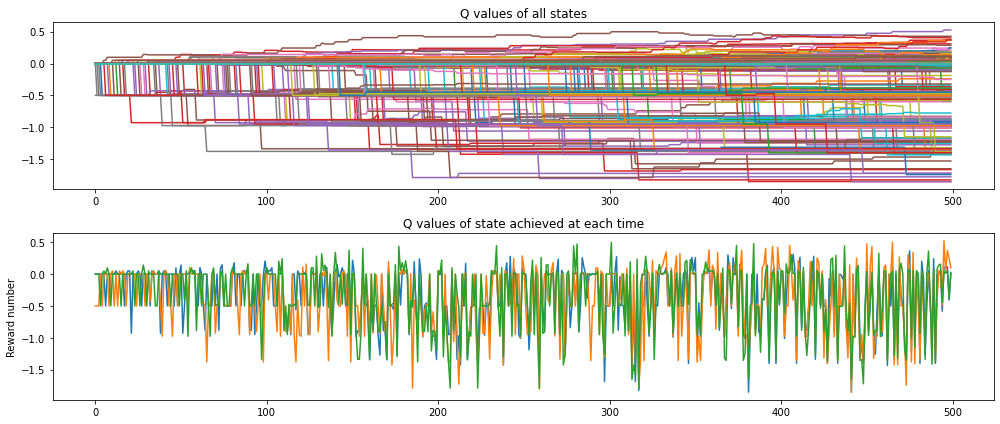

In [69]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 6))
ax = [fig.add_subplot(2, 1, x) for x in range(1, 3)]
ax[0].plot(np.arange(0, len(q_states)), Q)
ax[0].set_title('Q values of all states')
ax[1].plot(np.arange(0, len(q_states)), q_achieved)
ax[1].set_title('Q values of state achieved at each time')
ax[1].set_ylabel('Reward number')

plt.tight_layout()
plt.show()


OK, now let's try running it for a much longer period -- say, 5000 complete games.  We won't ask it to print out any states this time.

In [70]:
scores, q_achieved, q_states = pong_game.run(m_games=5000, states=[])

print('The number of games played was',len(scores))
print('The number of video frames was',len(q_states))
print('The size of each returned Q-matrix was',q_states[0].shape)


Completed 0 games, 2 rewards, 663 frames, score 6, max score 7
Completed 1 games, 6 rewards, 1747 frames, score 3, max score 7
Completed 2 games, 7 rewards, 1928 frames, score 0, max score 7
Completed 3 games, 8 rewards, 2136 frames, score 0, max score 7
Completed 4 games, 9 rewards, 2317 frames, score 0, max score 7
Completed 5 games, 13 rewards, 3044 frames, score 3, max score 7
Completed 6 games, 14 rewards, 3298 frames, score 0, max score 7
Completed 7 games, 15 rewards, 3506 frames, score 0, max score 7
Completed 8 games, 18 rewards, 4460 frames, score 2, max score 7
Completed 9 games, 22 rewards, 5534 frames, score 3, max score 7
Completed 10 games, 25 rewards, 6225 frames, score 2, max score 7
Completed 11 games, 27 rewards, 6593 frames, score 1, max score 7
Completed 12 games, 30 rewards, 7084 frames, score 2, max score 7
Completed 13 games, 32 rewards, 8050 frames, score 1, max score 7
Completed 14 games, 33 rewards, 8258 frames, score 0, max score 7
Completed 15 games, 35 rew

Completed 124 games, 267 rewards, 63563 frames, score 6, max score 8
Completed 125 games, 268 rewards, 63744 frames, score 0, max score 8
Completed 126 games, 272 rewards, 64656 frames, score 3, max score 8
Completed 127 games, 273 rewards, 64864 frames, score 0, max score 8
Completed 128 games, 274 rewards, 65118 frames, score 0, max score 8
Completed 129 games, 281 rewards, 66461 frames, score 6, max score 8
Completed 130 games, 283 rewards, 67637 frames, score 1, max score 8
Completed 131 games, 289 rewards, 69379 frames, score 5, max score 8
Completed 132 games, 293 rewards, 70129 frames, score 3, max score 8
Completed 133 games, 295 rewards, 70600 frames, score 1, max score 8
Completed 134 games, 296 rewards, 70781 frames, score 0, max score 8
Completed 135 games, 298 rewards, 71244 frames, score 1, max score 8
Completed 136 games, 301 rewards, 71934 frames, score 2, max score 8
Completed 137 games, 302 rewards, 72188 frames, score 0, max score 8
Completed 138 games, 304 rewards, 

Completed 242 games, 531 rewards, 126847 frames, score 0, max score 13
Completed 243 games, 532 rewards, 127055 frames, score 0, max score 13
Completed 244 games, 536 rewards, 128388 frames, score 3, max score 13
Completed 245 games, 537 rewards, 128642 frames, score 0, max score 13
Completed 246 games, 542 rewards, 130157 frames, score 4, max score 13
Completed 247 games, 544 rewards, 130563 frames, score 1, max score 13
Completed 248 games, 548 rewards, 131477 frames, score 3, max score 13
Completed 249 games, 550 rewards, 132396 frames, score 1, max score 13
Completed 250 games, 556 rewards, 136453 frames, score 5, max score 13
Completed 251 games, 558 rewards, 136635 frames, score 1, max score 13
Completed 252 games, 559 rewards, 136889 frames, score 0, max score 13
Completed 253 games, 560 rewards, 137143 frames, score 0, max score 13
Completed 254 games, 565 rewards, 137969 frames, score 4, max score 13
Completed 255 games, 567 rewards, 138559 frames, score 1, max score 13
Comple

Completed 472 games, 1356 rewards, 338137 frames, score 10, max score 18
Completed 473 games, 1359 rewards, 339593 frames, score 2, max score 18
Completed 474 games, 1362 rewards, 340084 frames, score 2, max score 18
Completed 475 games, 1368 rewards, 342157 frames, score 5, max score 18
Completed 476 games, 1375 rewards, 344487 frames, score 6, max score 18
Completed 477 games, 1379 rewards, 345641 frames, score 3, max score 18
Completed 478 games, 1384 rewards, 347077 frames, score 4, max score 18
Completed 479 games, 1390 rewards, 348106 frames, score 5, max score 18
Completed 480 games, 1395 rewards, 349205 frames, score 4, max score 18
Completed 481 games, 1400 rewards, 351631 frames, score 4, max score 18
Completed 482 games, 1404 rewards, 352558 frames, score 3, max score 18
Completed 483 games, 1406 rewards, 352995 frames, score 1, max score 18
Completed 484 games, 1412 rewards, 354152 frames, score 5, max score 18
Completed 485 games, 1418 rewards, 355199 frames, score 5, max 

Completed 586 games, 1803 rewards, 452072 frames, score 3, max score 18
Completed 587 games, 1807 rewards, 452717 frames, score 3, max score 18
Completed 588 games, 1813 rewards, 453830 frames, score 5, max score 18
Completed 589 games, 1817 rewards, 455450 frames, score 3, max score 18
Completed 590 games, 1818 rewards, 455631 frames, score 0, max score 18
Completed 591 games, 1819 rewards, 455885 frames, score 0, max score 18
Completed 592 games, 1822 rewards, 456685 frames, score 2, max score 18
Completed 593 games, 1823 rewards, 456893 frames, score 0, max score 18
Completed 594 games, 1824 rewards, 457074 frames, score 0, max score 18
Completed 595 games, 1825 rewards, 457328 frames, score 0, max score 18
Completed 596 games, 1833 rewards, 460166 frames, score 7, max score 18
Completed 597 games, 1838 rewards, 461119 frames, score 4, max score 18
Completed 598 games, 1844 rewards, 463275 frames, score 5, max score 18
Completed 599 games, 1848 rewards, 464476 frames, score 3, max s

Completed 703 games, 2343 rewards, 587902 frames, score 12, max score 22
Completed 704 games, 2351 rewards, 592206 frames, score 7, max score 22
Completed 705 games, 2353 rewards, 592703 frames, score 1, max score 22
Completed 706 games, 2357 rewards, 593689 frames, score 3, max score 22
Completed 707 games, 2360 rewards, 594480 frames, score 2, max score 22
Completed 708 games, 2363 rewards, 595065 frames, score 2, max score 22
Completed 709 games, 2365 rewards, 595502 frames, score 1, max score 22
Completed 710 games, 2369 rewards, 598131 frames, score 3, max score 22
Completed 711 games, 2371 rewards, 598628 frames, score 1, max score 22
Completed 712 games, 2375 rewards, 599758 frames, score 3, max score 22
Completed 713 games, 2383 rewards, 601176 frames, score 7, max score 22
Completed 714 games, 2386 rewards, 603200 frames, score 2, max score 22
Completed 715 games, 2395 rewards, 604616 frames, score 8, max score 22
Completed 716 games, 2397 rewards, 605535 frames, score 1, max 

Completed 820 games, 2851 rewards, 724925 frames, score 2, max score 22
Completed 821 games, 2855 rewards, 726172 frames, score 3, max score 22
Completed 822 games, 2859 rewards, 726836 frames, score 3, max score 22
Completed 823 games, 2863 rewards, 727703 frames, score 3, max score 22
Completed 824 games, 2869 rewards, 728963 frames, score 5, max score 22
Completed 825 games, 2871 rewards, 729514 frames, score 1, max score 22
Completed 826 games, 2877 rewards, 731201 frames, score 5, max score 22
Completed 827 games, 2880 rewards, 732018 frames, score 2, max score 22
Completed 828 games, 2881 rewards, 732199 frames, score 0, max score 22
Completed 829 games, 2891 rewards, 734059 frames, score 9, max score 22
Completed 830 games, 2895 rewards, 735093 frames, score 3, max score 22
Completed 831 games, 2897 rewards, 735507 frames, score 1, max score 22
Completed 832 games, 2901 rewards, 736182 frames, score 3, max score 22
Completed 833 games, 2910 rewards, 737991 frames, score 8, max s

Completed 935 games, 3351 rewards, 851260 frames, score 1, max score 22
Completed 936 games, 3355 rewards, 852040 frames, score 3, max score 22
Completed 937 games, 3357 rewards, 852477 frames, score 1, max score 22
Completed 938 games, 3358 rewards, 852658 frames, score 0, max score 22
Completed 939 games, 3359 rewards, 852839 frames, score 0, max score 22
Completed 940 games, 3360 rewards, 853093 frames, score 0, max score 22
Completed 941 games, 3363 rewards, 854407 frames, score 2, max score 22
Completed 942 games, 3364 rewards, 854615 frames, score 0, max score 22
Completed 943 games, 3372 rewards, 856388 frames, score 7, max score 22
Completed 944 games, 3378 rewards, 859469 frames, score 5, max score 22
Completed 945 games, 3379 rewards, 859677 frames, score 0, max score 22
Completed 946 games, 3380 rewards, 859885 frames, score 0, max score 22
Completed 947 games, 3382 rewards, 860313 frames, score 1, max score 22
Completed 948 games, 3384 rewards, 860741 frames, score 1, max s

Completed 1051 games, 3814 rewards, 966544 frames, score 5, max score 22
Completed 1052 games, 3815 rewards, 966798 frames, score 0, max score 22
Completed 1053 games, 3816 rewards, 967006 frames, score 0, max score 22
Completed 1054 games, 3821 rewards, 968619 frames, score 4, max score 22
Completed 1055 games, 3822 rewards, 968827 frames, score 0, max score 22
Completed 1056 games, 3823 rewards, 969008 frames, score 0, max score 22
Completed 1057 games, 3826 rewards, 969596 frames, score 2, max score 22
Completed 1058 games, 3828 rewards, 970147 frames, score 1, max score 22
Completed 1059 games, 3833 rewards, 971591 frames, score 4, max score 22
Completed 1060 games, 3841 rewards, 974405 frames, score 7, max score 22
Completed 1061 games, 3843 rewards, 974837 frames, score 1, max score 22
Completed 1062 games, 3851 rewards, 976749 frames, score 7, max score 22
Completed 1063 games, 3857 rewards, 977838 frames, score 5, max score 22
Completed 1064 games, 3863 rewards, 979358 frames, 

Completed 1163 games, 4290 rewards, 1082266 frames, score 10, max score 22
Completed 1164 games, 4293 rewards, 1082820 frames, score 2, max score 22
Completed 1165 games, 4302 rewards, 1084414 frames, score 8, max score 22
Completed 1166 games, 4303 rewards, 1084668 frames, score 0, max score 22
Completed 1167 games, 4316 rewards, 1087014 frames, score 12, max score 22
Completed 1168 games, 4319 rewards, 1087949 frames, score 2, max score 22
Completed 1169 games, 4325 rewards, 1089331 frames, score 5, max score 22
Completed 1170 games, 4331 rewards, 1092098 frames, score 5, max score 22
Completed 1171 games, 4333 rewards, 1092688 frames, score 1, max score 22
Completed 1172 games, 4338 rewards, 1093523 frames, score 4, max score 22
Completed 1173 games, 4340 rewards, 1094011 frames, score 1, max score 22
Completed 1174 games, 4357 rewards, 1097621 frames, score 16, max score 22
Completed 1175 games, 4361 rewards, 1098512 frames, score 3, max score 22
Completed 1176 games, 4366 rewards,

Completed 1274 games, 4820 rewards, 1206837 frames, score 2, max score 22
Completed 1275 games, 4823 rewards, 1207711 frames, score 2, max score 22
Completed 1276 games, 4825 rewards, 1208174 frames, score 1, max score 22
Completed 1277 games, 4829 rewards, 1209062 frames, score 3, max score 22
Completed 1278 games, 4831 rewards, 1209490 frames, score 1, max score 22
Completed 1279 games, 4835 rewards, 1210214 frames, score 3, max score 22
Completed 1280 games, 4841 rewards, 1211629 frames, score 5, max score 22
Completed 1281 games, 4846 rewards, 1212669 frames, score 4, max score 22
Completed 1282 games, 4850 rewards, 1213886 frames, score 3, max score 22
Completed 1283 games, 4851 rewards, 1214140 frames, score 0, max score 22
Completed 1284 games, 4853 rewards, 1214554 frames, score 1, max score 22
Completed 1285 games, 4854 rewards, 1214808 frames, score 0, max score 22
Completed 1286 games, 4859 rewards, 1216465 frames, score 4, max score 22
Completed 1287 games, 4860 rewards, 12

Completed 1496 games, 5767 rewards, 1449265 frames, score 8, max score 22
Completed 1497 games, 5768 rewards, 1449519 frames, score 0, max score 22
Completed 1498 games, 5773 rewards, 1450368 frames, score 4, max score 22
Completed 1499 games, 5782 rewards, 1454207 frames, score 8, max score 22
Completed 1500 games, 5788 rewards, 1455335 frames, score 5, max score 22
Completed 1501 games, 5790 rewards, 1455763 frames, score 1, max score 22
Completed 1502 games, 5792 rewards, 1456168 frames, score 1, max score 22
Completed 1503 games, 5804 rewards, 1460543 frames, score 11, max score 22
Completed 1504 games, 5809 rewards, 1461576 frames, score 4, max score 22
Completed 1505 games, 5813 rewards, 1462399 frames, score 3, max score 22
Completed 1506 games, 5817 rewards, 1463263 frames, score 3, max score 22
Completed 1507 games, 5819 rewards, 1463691 frames, score 1, max score 22
Completed 1508 games, 5820 rewards, 1463872 frames, score 0, max score 22
Completed 1509 games, 5827 rewards, 1

Completed 1610 games, 6172 rewards, 1548946 frames, score 2, max score 22
Completed 1611 games, 6173 rewards, 1549127 frames, score 0, max score 22
Completed 1612 games, 6174 rewards, 1549335 frames, score 0, max score 22
Completed 1613 games, 6175 rewards, 1549516 frames, score 0, max score 22
Completed 1614 games, 6177 rewards, 1550250 frames, score 1, max score 22
Completed 1615 games, 6179 rewards, 1550747 frames, score 1, max score 22
Completed 1616 games, 6181 rewards, 1551099 frames, score 1, max score 22
Completed 1617 games, 6184 rewards, 1551653 frames, score 2, max score 22
Completed 1618 games, 6185 rewards, 1551907 frames, score 0, max score 22
Completed 1619 games, 6187 rewards, 1552395 frames, score 1, max score 22
Completed 1620 games, 6188 rewards, 1552603 frames, score 0, max score 22
Completed 1621 games, 6189 rewards, 1552784 frames, score 0, max score 22
Completed 1622 games, 6192 rewards, 1553399 frames, score 2, max score 22
Completed 1623 games, 6193 rewards, 15

Completed 1721 games, 6501 rewards, 1628909 frames, score 4, max score 22
Completed 1722 games, 6504 rewards, 1629582 frames, score 2, max score 22
Completed 1723 games, 6511 rewards, 1631219 frames, score 6, max score 22
Completed 1724 games, 6513 rewards, 1631753 frames, score 1, max score 22
Completed 1725 games, 6519 rewards, 1632782 frames, score 5, max score 22
Completed 1726 games, 6538 rewards, 1638718 frames, score 18, max score 22
Completed 1727 games, 6543 rewards, 1639785 frames, score 4, max score 22
Completed 1728 games, 6552 rewards, 1643838 frames, score 8, max score 22
Completed 1729 games, 6556 rewards, 1645059 frames, score 3, max score 22
Completed 1730 games, 6558 rewards, 1645610 frames, score 1, max score 22
Completed 1731 games, 6559 rewards, 1645818 frames, score 0, max score 22
Completed 1732 games, 6564 rewards, 1646979 frames, score 4, max score 22
Completed 1733 games, 6565 rewards, 1647233 frames, score 0, max score 22
Completed 1734 games, 6566 rewards, 1

Completed 1832 games, 6876 rewards, 1720243 frames, score 5, max score 22
Completed 1833 games, 6882 rewards, 1721796 frames, score 5, max score 22
Completed 1834 games, 6883 rewards, 1721977 frames, score 0, max score 22
Completed 1835 games, 6889 rewards, 1723184 frames, score 5, max score 22
Completed 1836 games, 6891 rewards, 1723774 frames, score 1, max score 22
Completed 1837 games, 6896 rewards, 1725548 frames, score 4, max score 22
Completed 1838 games, 6898 rewards, 1725916 frames, score 1, max score 22
Completed 1839 games, 6899 rewards, 1726097 frames, score 0, max score 22
Completed 1840 games, 6900 rewards, 1726351 frames, score 0, max score 22
Completed 1841 games, 6901 rewards, 1726605 frames, score 0, max score 22
Completed 1842 games, 6906 rewards, 1727555 frames, score 4, max score 22
Completed 1843 games, 6907 rewards, 1727809 frames, score 0, max score 22
Completed 1844 games, 6908 rewards, 1728063 frames, score 0, max score 22
Completed 1845 games, 6915 rewards, 17

Completed 1949 games, 7273 rewards, 1822736 frames, score 1, max score 22
Completed 1950 games, 7276 rewards, 1823567 frames, score 2, max score 22
Completed 1951 games, 7280 rewards, 1825051 frames, score 3, max score 22
Completed 1952 games, 7283 rewards, 1825663 frames, score 2, max score 22
Completed 1953 games, 7285 rewards, 1826100 frames, score 1, max score 22
Completed 1954 games, 7286 rewards, 1826308 frames, score 0, max score 22
Completed 1955 games, 7289 rewards, 1826855 frames, score 2, max score 22
Completed 1956 games, 7293 rewards, 1827767 frames, score 3, max score 22
Completed 1957 games, 7296 rewards, 1828663 frames, score 2, max score 22
Completed 1958 games, 7300 rewards, 1829343 frames, score 3, max score 22
Completed 1959 games, 7301 rewards, 1829524 frames, score 0, max score 22
Completed 1960 games, 7310 rewards, 1834735 frames, score 8, max score 22
Completed 1961 games, 7311 rewards, 1834989 frames, score 0, max score 22
Completed 1962 games, 7312 rewards, 18

Completed 2061 games, 7635 rewards, 1916273 frames, score 15, max score 22
Completed 2062 games, 7638 rewards, 1917340 frames, score 2, max score 22
Completed 2063 games, 7643 rewards, 1918422 frames, score 4, max score 22
Completed 2064 games, 7647 rewards, 1919416 frames, score 3, max score 22
Completed 2065 games, 7650 rewards, 1920135 frames, score 2, max score 22
Completed 2066 games, 7654 rewards, 1920875 frames, score 3, max score 22
Completed 2067 games, 7661 rewards, 1922337 frames, score 6, max score 22
Completed 2068 games, 7666 rewards, 1923279 frames, score 4, max score 22
Completed 2069 games, 7680 rewards, 1925965 frames, score 13, max score 22
Completed 2070 games, 7684 rewards, 1927072 frames, score 3, max score 22
Completed 2071 games, 7685 rewards, 1927253 frames, score 0, max score 22
Completed 2072 games, 7689 rewards, 1928284 frames, score 3, max score 22
Completed 2073 games, 7690 rewards, 1928492 frames, score 0, max score 22
Completed 2074 games, 7694 rewards, 

Completed 2174 games, 8224 rewards, 2077268 frames, score 6, max score 22
Completed 2175 games, 8230 rewards, 2078495 frames, score 5, max score 22
Completed 2176 games, 8238 rewards, 2079728 frames, score 7, max score 22
Completed 2177 games, 8240 rewards, 2080111 frames, score 1, max score 22
Completed 2178 games, 8242 rewards, 2080662 frames, score 1, max score 22
Completed 2179 games, 8246 rewards, 2081371 frames, score 3, max score 22
Completed 2180 games, 8253 rewards, 2083026 frames, score 6, max score 22
Completed 2181 games, 8255 rewards, 2083486 frames, score 1, max score 22
Completed 2182 games, 8257 rewards, 2084020 frames, score 1, max score 22
Completed 2183 games, 8260 rewards, 2084592 frames, score 2, max score 22
Completed 2184 games, 8265 rewards, 2085358 frames, score 4, max score 22
Completed 2185 games, 8272 rewards, 2086594 frames, score 6, max score 22
Completed 2186 games, 8277 rewards, 2087392 frames, score 4, max score 22
Completed 2187 games, 8286 rewards, 20

Completed 2286 games, 8817 rewards, 2223188 frames, score 10, max score 28
Completed 2287 games, 8818 rewards, 2223396 frames, score 0, max score 28
Completed 2288 games, 8821 rewards, 2224608 frames, score 2, max score 28
Completed 2289 games, 8823 rewards, 2225527 frames, score 1, max score 28
Completed 2290 games, 8824 rewards, 2225735 frames, score 0, max score 28
Completed 2291 games, 8834 rewards, 2227493 frames, score 9, max score 28
Completed 2292 games, 8836 rewards, 2228044 frames, score 1, max score 28
Completed 2293 games, 8842 rewards, 2229564 frames, score 5, max score 28
Completed 2294 games, 8846 rewards, 2230173 frames, score 3, max score 28
Completed 2295 games, 8854 rewards, 2231475 frames, score 7, max score 28
Completed 2296 games, 8857 rewards, 2232216 frames, score 2, max score 28
Completed 2297 games, 8858 rewards, 2232397 frames, score 0, max score 28
Completed 2298 games, 8862 rewards, 2233102 frames, score 3, max score 28
Completed 2299 games, 8869 rewards, 2

Completed 2403 games, 9295 rewards, 2350748 frames, score 3, max score 28
Completed 2404 games, 9299 rewards, 2351952 frames, score 3, max score 28
Completed 2405 games, 9302 rewards, 2352540 frames, score 2, max score 28
Completed 2406 games, 9308 rewards, 2355088 frames, score 5, max score 28
Completed 2407 games, 9313 rewards, 2356013 frames, score 4, max score 28
Completed 2408 games, 9321 rewards, 2358143 frames, score 7, max score 28
Completed 2409 games, 9323 rewards, 2358655 frames, score 1, max score 28
Completed 2410 games, 9328 rewards, 2359753 frames, score 4, max score 28
Completed 2411 games, 9352 rewards, 2368117 frames, score 23, max score 28
Completed 2412 games, 9355 rewards, 2369052 frames, score 2, max score 28
Completed 2413 games, 9357 rewards, 2369419 frames, score 1, max score 28
Completed 2414 games, 9365 rewards, 2371281 frames, score 7, max score 28
Completed 2415 games, 9368 rewards, 2371889 frames, score 2, max score 28
Completed 2416 games, 9369 rewards, 2

Completed 2515 games, 10084 rewards, 2572470 frames, score 1, max score 40
Completed 2516 games, 10087 rewards, 2572996 frames, score 2, max score 40
Completed 2517 games, 10090 rewards, 2573899 frames, score 2, max score 40
Completed 2518 games, 10104 rewards, 2576268 frames, score 13, max score 40
Completed 2519 games, 10112 rewards, 2577823 frames, score 7, max score 40
Completed 2520 games, 10152 rewards, 2586186 frames, score 39, max score 40
Completed 2521 games, 10153 rewards, 2586367 frames, score 0, max score 40
Completed 2522 games, 10155 rewards, 2586918 frames, score 1, max score 40
Completed 2523 games, 10167 rewards, 2589450 frames, score 11, max score 40
Completed 2524 games, 10172 rewards, 2590382 frames, score 4, max score 40
Completed 2525 games, 10183 rewards, 2592606 frames, score 10, max score 40
Completed 2526 games, 10187 rewards, 2593495 frames, score 3, max score 40
Completed 2527 games, 10188 rewards, 2593676 frames, score 0, max score 40
Completed 2528 games,

Completed 2625 games, 11383 rewards, 2855910 frames, score 45, max score 45
Completed 2626 games, 11386 rewards, 2856817 frames, score 2, max score 45
Completed 2627 games, 11388 rewards, 2857184 frames, score 1, max score 45
Completed 2628 games, 11405 rewards, 2861124 frames, score 16, max score 45
Completed 2629 games, 11410 rewards, 2861947 frames, score 4, max score 45
Completed 2630 games, 11420 rewards, 2863496 frames, score 9, max score 45
Completed 2631 games, 11430 rewards, 2865112 frames, score 9, max score 45
Completed 2632 games, 11440 rewards, 2866830 frames, score 9, max score 45
Completed 2633 games, 11453 rewards, 2871458 frames, score 12, max score 45
Completed 2634 games, 11456 rewards, 2872020 frames, score 2, max score 45
Completed 2635 games, 11473 rewards, 2874589 frames, score 16, max score 45
Completed 2636 games, 11475 rewards, 2875165 frames, score 1, max score 45
Completed 2637 games, 11487 rewards, 2877428 frames, score 11, max score 45
Completed 2638 games

Completed 2734 games, 13059 rewards, 3211881 frames, score 19, max score 64
Completed 2735 games, 13062 rewards, 3212964 frames, score 2, max score 64
Completed 2736 games, 13071 rewards, 3216050 frames, score 8, max score 64
Completed 2737 games, 13077 rewards, 3217669 frames, score 5, max score 64
Completed 2738 games, 13081 rewards, 3219377 frames, score 3, max score 64
Completed 2739 games, 13120 rewards, 3230316 frames, score 38, max score 64
Completed 2740 games, 13149 rewards, 3235256 frames, score 28, max score 64
Completed 2741 games, 13159 rewards, 3240547 frames, score 9, max score 64
Completed 2742 games, 13164 rewards, 3241359 frames, score 4, max score 64
Completed 2743 games, 13179 rewards, 3243647 frames, score 14, max score 64
Completed 2744 games, 13204 rewards, 3248402 frames, score 24, max score 64
Completed 2745 games, 13205 rewards, 3248610 frames, score 0, max score 64
Completed 2746 games, 13217 rewards, 3250756 frames, score 11, max score 64
Completed 2747 game

Completed 2844 games, 15243 rewards, 3712066 frames, score 34, max score 80
Completed 2845 games, 15299 rewards, 3725439 frames, score 55, max score 80
Completed 2846 games, 15315 rewards, 3730891 frames, score 15, max score 80
Completed 2847 games, 15361 rewards, 3744594 frames, score 45, max score 80
Completed 2848 games, 15366 rewards, 3745790 frames, score 4, max score 80
Completed 2849 games, 15381 rewards, 3748261 frames, score 14, max score 80
Completed 2850 games, 15394 rewards, 3750686 frames, score 12, max score 80
Completed 2851 games, 15423 rewards, 3754974 frames, score 28, max score 80
Completed 2852 games, 15488 rewards, 3772874 frames, score 64, max score 80
Completed 2853 games, 15519 rewards, 3777481 frames, score 30, max score 80
Completed 2854 games, 15526 rewards, 3778773 frames, score 6, max score 80
Completed 2855 games, 15544 rewards, 3781779 frames, score 17, max score 80
Completed 2856 games, 15557 rewards, 3784358 frames, score 12, max score 80
Completed 2857

Completed 2955 games, 17199 rewards, 4149854 frames, score 27, max score 98
Completed 2956 games, 17225 rewards, 4154188 frames, score 25, max score 98
Completed 2957 games, 17239 rewards, 4157153 frames, score 13, max score 98
Completed 2958 games, 17259 rewards, 4160429 frames, score 19, max score 98
Completed 2959 games, 17263 rewards, 4161194 frames, score 3, max score 98
Completed 2960 games, 17267 rewards, 4161943 frames, score 3, max score 98
Completed 2961 games, 17280 rewards, 4166245 frames, score 12, max score 98
Completed 2962 games, 17303 rewards, 4169697 frames, score 22, max score 98
Completed 2963 games, 17304 rewards, 4169951 frames, score 0, max score 98
Completed 2964 games, 17305 rewards, 4170205 frames, score 0, max score 98
Completed 2965 games, 17311 rewards, 4171583 frames, score 5, max score 98
Completed 2966 games, 17312 rewards, 4171837 frames, score 0, max score 98
Completed 2967 games, 17313 rewards, 4172091 frames, score 0, max score 98
Completed 2968 game

Completed 3064 games, 18947 rewards, 4521107 frames, score 1, max score 99
Completed 3065 games, 18950 rewards, 4521760 frames, score 2, max score 99
Completed 3066 games, 18956 rewards, 4525287 frames, score 5, max score 99
Completed 3067 games, 18962 rewards, 4526328 frames, score 5, max score 99
Completed 3068 games, 18976 rewards, 4533159 frames, score 13, max score 99
Completed 3069 games, 18977 rewards, 4533367 frames, score 0, max score 99
Completed 3070 games, 19009 rewards, 4541808 frames, score 31, max score 99
Completed 3071 games, 19014 rewards, 4543906 frames, score 4, max score 99
Completed 3072 games, 19017 rewards, 4544516 frames, score 2, max score 99
Completed 3073 games, 19023 rewards, 4548343 frames, score 5, max score 99
Completed 3074 games, 19029 rewards, 4549537 frames, score 5, max score 99
Completed 3075 games, 19044 rewards, 4551902 frames, score 14, max score 99
Completed 3076 games, 19072 rewards, 4561574 frames, score 27, max score 99
Completed 3077 games,

Completed 3173 games, 20884 rewards, 5007462 frames, score 16, max score 99
Completed 3174 games, 20908 rewards, 5013234 frames, score 23, max score 99
Completed 3175 games, 20910 rewards, 5013824 frames, score 1, max score 99
Completed 3176 games, 20929 rewards, 5017001 frames, score 18, max score 99
Completed 3177 games, 20934 rewards, 5017934 frames, score 4, max score 99
Completed 3178 games, 20941 rewards, 5019738 frames, score 6, max score 99
Completed 3179 games, 20944 rewards, 5021113 frames, score 2, max score 99
Completed 3180 games, 20952 rewards, 5022659 frames, score 7, max score 99
Completed 3181 games, 20954 rewards, 5023057 frames, score 1, max score 99
Completed 3182 games, 20956 rewards, 5023471 frames, score 1, max score 99
Completed 3183 games, 21009 rewards, 5034306 frames, score 52, max score 99
Completed 3184 games, 21031 rewards, 5039767 frames, score 21, max score 99
Completed 3185 games, 21079 rewards, 5054039 frames, score 47, max score 99
Completed 3186 game

Completed 3283 games, 22513 rewards, 5371938 frames, score 3, max score 99
Completed 3284 games, 22515 rewards, 5372489 frames, score 1, max score 99
Completed 3285 games, 22535 rewards, 5380536 frames, score 19, max score 99
Completed 3286 games, 22556 rewards, 5386658 frames, score 20, max score 99
Completed 3287 games, 22560 rewards, 5387418 frames, score 3, max score 99
Completed 3288 games, 22574 rewards, 5389668 frames, score 13, max score 99
Completed 3289 games, 22583 rewards, 5394915 frames, score 8, max score 99
Completed 3290 games, 22619 rewards, 5402321 frames, score 35, max score 99
Completed 3291 games, 22625 rewards, 5405497 frames, score 5, max score 99
Completed 3292 games, 22632 rewards, 5406888 frames, score 6, max score 99
Completed 3293 games, 22703 rewards, 5422048 frames, score 70, max score 99
Completed 3294 games, 22708 rewards, 5424860 frames, score 4, max score 99
Completed 3295 games, 22714 rewards, 5425900 frames, score 5, max score 99
Completed 3296 games

Completed 3392 games, 25749 rewards, 6026968 frames, score 92, max score 216
Completed 3393 games, 25849 rewards, 6042490 frames, score 99, max score 216
Completed 3394 games, 25901 rewards, 6051074 frames, score 51, max score 216
Completed 3395 games, 25926 rewards, 6054971 frames, score 24, max score 216
Completed 3396 games, 25949 rewards, 6058837 frames, score 22, max score 216
Completed 3397 games, 26205 rewards, 6109373 frames, score 255, max score 255
Completed 3398 games, 26317 rewards, 6130477 frames, score 111, max score 255
Completed 3399 games, 26349 rewards, 6135173 frames, score 31, max score 255
Completed 3400 games, 26351 rewards, 6135540 frames, score 1, max score 255
Completed 3401 games, 26527 rewards, 6162408 frames, score 175, max score 255
Completed 3402 games, 26625 rewards, 6182334 frames, score 97, max score 255
Completed 3403 games, 26661 rewards, 6187882 frames, score 35, max score 255
Completed 3404 games, 26740 rewards, 6199876 frames, score 78, max score 2

Completed 3499 games, 30470 rewards, 6928552 frames, score 20, max score 255
Completed 3500 games, 30492 rewards, 6932122 frames, score 21, max score 255
Completed 3501 games, 30517 rewards, 6936071 frames, score 24, max score 255
Completed 3502 games, 30548 rewards, 6940976 frames, score 30, max score 255
Completed 3503 games, 30602 rewards, 6959637 frames, score 53, max score 255
Completed 3504 games, 30611 rewards, 6961098 frames, score 8, max score 255
Completed 3505 games, 30632 rewards, 6965487 frames, score 20, max score 255
Completed 3506 games, 30644 rewards, 6967330 frames, score 11, max score 255
Completed 3507 games, 30672 rewards, 6971425 frames, score 27, max score 255
Completed 3508 games, 30681 rewards, 6973394 frames, score 8, max score 255
Completed 3509 games, 30708 rewards, 6979176 frames, score 26, max score 255
Completed 3510 games, 30730 rewards, 6982532 frames, score 21, max score 255
Completed 3511 games, 30787 rewards, 6991387 frames, score 56, max score 255
C

Completed 3607 games, 34400 rewards, 7789044 frames, score 29, max score 255
Completed 3608 games, 34419 rewards, 7792184 frames, score 18, max score 255
Completed 3609 games, 34450 rewards, 7803822 frames, score 30, max score 255
Completed 3610 games, 34480 rewards, 7811272 frames, score 29, max score 255
Completed 3611 games, 34501 rewards, 7814974 frames, score 20, max score 255
Completed 3612 games, 34530 rewards, 7820414 frames, score 28, max score 255
Completed 3613 games, 34557 rewards, 7824881 frames, score 26, max score 255
Completed 3614 games, 34560 rewards, 7825991 frames, score 2, max score 255
Completed 3615 games, 34563 rewards, 7826621 frames, score 2, max score 255
Completed 3616 games, 34625 rewards, 7836995 frames, score 61, max score 255
Completed 3617 games, 34629 rewards, 7837771 frames, score 3, max score 255
Completed 3618 games, 34637 rewards, 7839006 frames, score 7, max score 255
Completed 3619 games, 34662 rewards, 7853275 frames, score 24, max score 255
Com

Completed 3714 games, 36127 rewards, 8170123 frames, score 7, max score 255
Completed 3715 games, 36138 rewards, 8171863 frames, score 10, max score 255
Completed 3716 games, 36144 rewards, 8173026 frames, score 5, max score 255
Completed 3717 games, 36149 rewards, 8173981 frames, score 4, max score 255
Completed 3718 games, 36154 rewards, 8175243 frames, score 4, max score 255
Completed 3719 games, 36165 rewards, 8177074 frames, score 10, max score 255
Completed 3720 games, 36175 rewards, 8179580 frames, score 9, max score 255
Completed 3721 games, 36191 rewards, 8182121 frames, score 15, max score 255
Completed 3722 games, 36214 rewards, 8185531 frames, score 22, max score 255
Completed 3723 games, 36218 rewards, 8186333 frames, score 3, max score 255
Completed 3724 games, 36221 rewards, 8187789 frames, score 2, max score 255
Completed 3725 games, 36222 rewards, 8188043 frames, score 0, max score 255
Completed 3726 games, 36265 rewards, 8199921 frames, score 42, max score 255
Complet

Completed 3825 games, 37302 rewards, 8459992 frames, score 13, max score 255
Completed 3826 games, 37304 rewards, 8460406 frames, score 1, max score 255
Completed 3827 games, 37323 rewards, 8465035 frames, score 18, max score 255
Completed 3828 games, 37336 rewards, 8467405 frames, score 12, max score 255
Completed 3829 games, 37348 rewards, 8469649 frames, score 11, max score 255
Completed 3830 games, 37351 rewards, 8470240 frames, score 2, max score 255
Completed 3831 games, 37369 rewards, 8473476 frames, score 17, max score 255
Completed 3832 games, 37372 rewards, 8474262 frames, score 2, max score 255
Completed 3833 games, 37380 rewards, 8475953 frames, score 7, max score 255
Completed 3834 games, 37390 rewards, 8478109 frames, score 9, max score 255
Completed 3835 games, 37408 rewards, 8482774 frames, score 17, max score 255
Completed 3836 games, 37418 rewards, 8484818 frames, score 9, max score 255
Completed 3837 games, 37421 rewards, 8485298 frames, score 2, max score 255
Comple

Completed 3933 games, 38343 rewards, 8733552 frames, score 17, max score 255
Completed 3934 games, 38377 rewards, 8748772 frames, score 33, max score 255
Completed 3935 games, 38378 rewards, 8748980 frames, score 0, max score 255
Completed 3936 games, 38387 rewards, 8750447 frames, score 8, max score 255
Completed 3937 games, 38394 rewards, 8751683 frames, score 6, max score 255
Completed 3938 games, 38434 rewards, 8758455 frames, score 39, max score 255
Completed 3939 games, 38435 rewards, 8758636 frames, score 0, max score 255
Completed 3940 games, 38436 rewards, 8758844 frames, score 0, max score 255
Completed 3941 games, 38437 rewards, 8759098 frames, score 0, max score 255
Completed 3942 games, 38438 rewards, 8759306 frames, score 0, max score 255
Completed 3943 games, 38439 rewards, 8759487 frames, score 0, max score 255
Completed 3944 games, 38473 rewards, 8770133 frames, score 33, max score 255
Completed 3945 games, 38476 rewards, 8770703 frames, score 2, max score 255
Complete

Completed 4041 games, 39236 rewards, 8982359 frames, score 11, max score 255
Completed 4042 games, 39245 rewards, 8984088 frames, score 8, max score 255
Completed 4043 games, 39251 rewards, 8985287 frames, score 5, max score 255
Completed 4044 games, 39255 rewards, 8986060 frames, score 3, max score 255
Completed 4045 games, 39267 rewards, 8988575 frames, score 11, max score 255
Completed 4046 games, 39268 rewards, 8988783 frames, score 0, max score 255
Completed 4047 games, 39295 rewards, 8995203 frames, score 26, max score 255
Completed 4048 games, 39305 rewards, 8999698 frames, score 9, max score 255
Completed 4049 games, 39324 rewards, 9005547 frames, score 18, max score 255
Completed 4050 games, 39334 rewards, 9008830 frames, score 9, max score 255
Completed 4051 games, 39341 rewards, 9010533 frames, score 6, max score 255
Completed 4052 games, 39345 rewards, 9011221 frames, score 3, max score 255
Completed 4053 games, 39346 rewards, 9011429 frames, score 0, max score 255
Complete

Completed 4151 games, 40399 rewards, 9259284 frames, score 17, max score 255
Completed 4152 games, 40415 rewards, 9264523 frames, score 15, max score 255
Completed 4153 games, 40436 rewards, 9271123 frames, score 20, max score 255
Completed 4154 games, 40448 rewards, 9273340 frames, score 11, max score 255
Completed 4155 games, 40489 rewards, 9290707 frames, score 40, max score 255
Completed 4156 games, 40504 rewards, 9293091 frames, score 14, max score 255
Completed 4157 games, 40557 rewards, 9306388 frames, score 52, max score 255
Completed 4158 games, 40577 rewards, 9314440 frames, score 19, max score 255
Completed 4159 games, 40599 rewards, 9317854 frames, score 21, max score 255
Completed 4160 games, 40602 rewards, 9318377 frames, score 2, max score 255
Completed 4161 games, 40605 rewards, 9318857 frames, score 2, max score 255
Completed 4162 games, 40608 rewards, 9319383 frames, score 2, max score 255
Completed 4163 games, 40619 rewards, 9321532 frames, score 10, max score 255
Co

Completed 4261 games, 41698 rewards, 9576723 frames, score 3, max score 255
Completed 4262 games, 41699 rewards, 9576904 frames, score 0, max score 255
Completed 4263 games, 41701 rewards, 9577302 frames, score 1, max score 255
Completed 4264 games, 41722 rewards, 9581062 frames, score 20, max score 255
Completed 4265 games, 41724 rewards, 9581981 frames, score 1, max score 255
Completed 4266 games, 41736 rewards, 9584194 frames, score 11, max score 255
Completed 4267 games, 41739 rewards, 9585569 frames, score 2, max score 255
Completed 4268 games, 41760 rewards, 9594483 frames, score 20, max score 255
Completed 4269 games, 41774 rewards, 9601507 frames, score 13, max score 255
Completed 4270 games, 41777 rewards, 9602169 frames, score 2, max score 255
Completed 4271 games, 41801 rewards, 9606082 frames, score 23, max score 255
Completed 4272 games, 41829 rewards, 9612192 frames, score 27, max score 255
Completed 4273 games, 41851 rewards, 9616587 frames, score 21, max score 255
Compl

Completed 4371 games, 43271 rewards, 9940329 frames, score 114, max score 255
Completed 4372 games, 43276 rewards, 9941323 frames, score 4, max score 255
Completed 4373 games, 43294 rewards, 9944689 frames, score 17, max score 255
Completed 4374 games, 43300 rewards, 9947597 frames, score 5, max score 255
Completed 4375 games, 43307 rewards, 9949184 frames, score 6, max score 255
Completed 4376 games, 43322 rewards, 9951565 frames, score 14, max score 255
Completed 4377 games, 43349 rewards, 9956235 frames, score 26, max score 255
Completed 4378 games, 43382 rewards, 9961047 frames, score 32, max score 255
Completed 4379 games, 43432 rewards, 9971912 frames, score 49, max score 255
Completed 4380 games, 43522 rewards, 9986982 frames, score 89, max score 255
Completed 4381 games, 43540 rewards, 9989914 frames, score 17, max score 255
Completed 4382 games, 43631 rewards, 10011354 frames, score 90, max score 255
Completed 4383 games, 43636 rewards, 10012962 frames, score 4, max score 255


Completed 4479 games, 46318 rewards, 10546626 frames, score 17, max score 255
Completed 4480 games, 46327 rewards, 10548412 frames, score 8, max score 255
Completed 4481 games, 46329 rewards, 10548779 frames, score 1, max score 255
Completed 4482 games, 46330 rewards, 10549033 frames, score 0, max score 255
Completed 4483 games, 46359 rewards, 10553363 frames, score 28, max score 255
Completed 4484 games, 46384 rewards, 10557294 frames, score 24, max score 255
Completed 4485 games, 46413 rewards, 10561575 frames, score 28, max score 255
Completed 4486 games, 46416 rewards, 10562163 frames, score 2, max score 255
Completed 4487 games, 46431 rewards, 10564663 frames, score 14, max score 255
Completed 4488 games, 46448 rewards, 10568243 frames, score 16, max score 255
Completed 4489 games, 46451 rewards, 10569034 frames, score 2, max score 255
Completed 4490 games, 46456 rewards, 10571505 frames, score 4, max score 255
Completed 4491 games, 46463 rewards, 10574434 frames, score 6, max sco

Completed 4585 games, 48876 rewards, 11055272 frames, score 104, max score 255
Completed 4586 games, 48887 rewards, 11058105 frames, score 10, max score 255
Completed 4587 games, 48917 rewards, 11062863 frames, score 29, max score 255
Completed 4588 games, 48929 rewards, 11066149 frames, score 11, max score 255
Completed 4589 games, 49057 rewards, 11085528 frames, score 127, max score 255
Completed 4590 games, 49063 rewards, 11086645 frames, score 5, max score 255
Completed 4591 games, 49107 rewards, 11093692 frames, score 43, max score 255
Completed 4592 games, 49249 rewards, 11117664 frames, score 141, max score 255
Completed 4593 games, 49329 rewards, 11130446 frames, score 79, max score 255
Completed 4594 games, 49342 rewards, 11133832 frames, score 12, max score 255
Completed 4595 games, 49512 rewards, 11165816 frames, score 169, max score 255
Completed 4596 games, 49517 rewards, 11166583 frames, score 4, max score 255
Completed 4597 games, 49558 rewards, 11173173 frames, score 40

Completed 4691 games, 53164 rewards, 11873523 frames, score 47, max score 255
Completed 4692 games, 53171 rewards, 11874682 frames, score 6, max score 255
Completed 4693 games, 53194 rewards, 11878480 frames, score 22, max score 255
Completed 4694 games, 53211 rewards, 11881246 frames, score 16, max score 255
Completed 4695 games, 53237 rewards, 11892756 frames, score 25, max score 255
Completed 4696 games, 53250 rewards, 11895473 frames, score 12, max score 255
Completed 4697 games, 53273 rewards, 11900238 frames, score 22, max score 255
Completed 4698 games, 53276 rewards, 11900840 frames, score 2, max score 255
Completed 4699 games, 53352 rewards, 11912232 frames, score 75, max score 255
Completed 4700 games, 53362 rewards, 11914062 frames, score 9, max score 255
Completed 4701 games, 53368 rewards, 11915322 frames, score 5, max score 255
Completed 4702 games, 53374 rewards, 11916325 frames, score 5, max score 255
Completed 4703 games, 53379 rewards, 11917113 frames, score 4, max sc

Completed 4799 games, 55734 rewards, 12432927 frames, score 0, max score 255
Completed 4800 games, 55748 rewards, 12436863 frames, score 13, max score 255
Completed 4801 games, 55753 rewards, 12437952 frames, score 4, max score 255
Completed 4802 games, 55780 rewards, 12443421 frames, score 26, max score 255
Completed 4803 games, 55792 rewards, 12445834 frames, score 11, max score 255
Completed 4804 games, 55803 rewards, 12448342 frames, score 10, max score 255
Completed 4805 games, 55829 rewards, 12457524 frames, score 25, max score 255
Completed 4806 games, 55849 rewards, 12462733 frames, score 19, max score 255
Completed 4807 games, 55868 rewards, 12470039 frames, score 18, max score 255
Completed 4808 games, 55879 rewards, 12471738 frames, score 10, max score 255
Completed 4809 games, 55886 rewards, 12474162 frames, score 6, max score 255
Completed 4810 games, 55944 rewards, 12492620 frames, score 57, max score 255
Completed 4811 games, 55989 rewards, 12501249 frames, score 44, max

Completed 4907 games, 57445 rewards, 12874772 frames, score 11, max score 255
Completed 4908 games, 57448 rewards, 12875445 frames, score 2, max score 255
Completed 4909 games, 57455 rewards, 12876996 frames, score 6, max score 255
Completed 4910 games, 57473 rewards, 12880261 frames, score 17, max score 255
Completed 4911 games, 57474 rewards, 12880469 frames, score 0, max score 255
Completed 4912 games, 57482 rewards, 12882761 frames, score 7, max score 255
Completed 4913 games, 57484 rewards, 12883258 frames, score 1, max score 255
Completed 4914 games, 57487 rewards, 12883859 frames, score 2, max score 255
Completed 4915 games, 57504 rewards, 12886491 frames, score 16, max score 255
Completed 4916 games, 57507 rewards, 12887387 frames, score 2, max score 255
Completed 4917 games, 57518 rewards, 12889800 frames, score 10, max score 255
Completed 4918 games, 57523 rewards, 12890958 frames, score 4, max score 255
Completed 4919 games, 57526 rewards, 12891588 frames, score 2, max score

Now let's plot the score, to see if it improved over time.  We will also plot the local average, averaged over 10 consecutive games, to see if that has improved.  Notice that we can use `np.convolve` to compute the local average.

These numbers are really noisy, with a really large maximum.  We will plot `np.log10(1+x)`, rather than x, so that we can better see the average numbers, and ignore the very large noisy spikes.

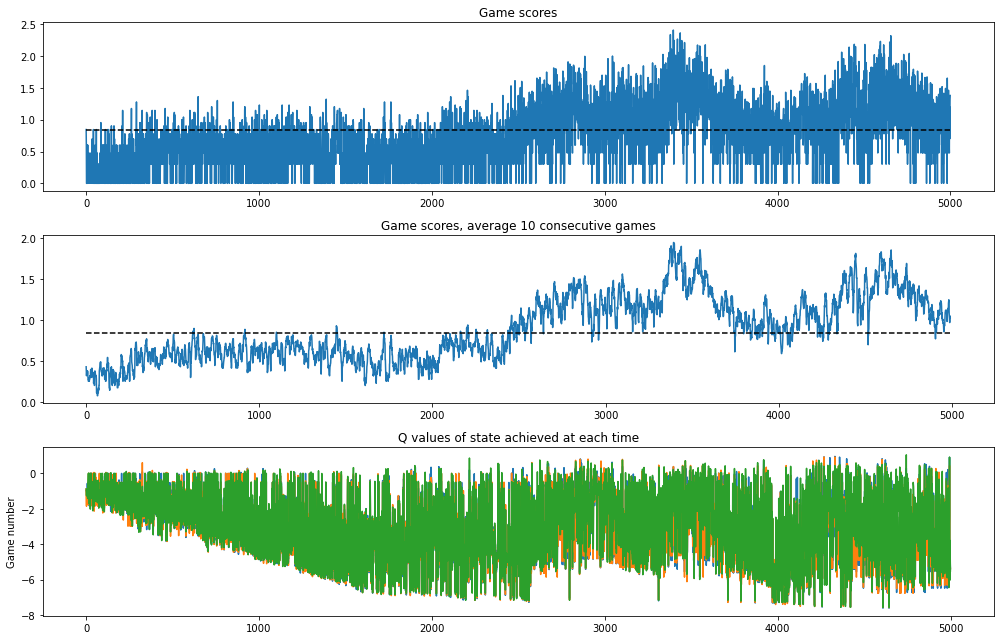

In [72]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 9))
ax = [fig.add_subplot(3, 1, x) for x in range(1, 4)]
ax[0].plot(np.arange(0, len(scores)), np.log10(1 + np.array(scores)))
ax[0].plot([0, 5000], np.log10([7, 7]), 'k--')
ax[0].set_title('Game scores')
ax[1].plot(np.arange(4991), np.log10(1 + np.convolve(np.ones(10) / 10, scores, mode='valid')))
ax[1].plot([0, 4991], np.log10([7, 7]), 'k--')
ax[1].set_title('Game scores, average 10 consecutive games')
ax[2].plot(np.arange(0, len(q_achieved)), q_achieved)
ax[2].set_title('Q values of state achieved at each time')
ax[2].set_ylabel('Game number')

plt.tight_layout()
plt.show()


Hooray, it has learned!  If you are getting a ten-game average score of better than 6, then you are ready to submit your model for grading.   In order to do that, you need to save the model:

In [73]:
q_learner.save('trained_model.npz')

<a id='section9'></a>

## Extra Credit

For extra credit, download the file <a href="mp11_extra.zip">mp11_extra.zip</a>.  The only important file in this package is:
* `tests/test_extra.py`: this contains extra tests that will evaluate your pre-trained `deep_q` learner, which should be in a file called `trained_model.pkl`.  For full credit, your model should achieve an average score of greater than 20, averaged over 10 consecutive games. 

With a quantized lookup table, it's probably not possible to achieve an average score of 20.  With a deep-Q learner, however, it is eminently possible.  In order to do the extra credit, therefore, you should just fill in the part of `submitted.py` that implements the `deep_q` learner, using pytorch to define a model structure, train it, save it, load it, and act on it.  This learner only needs to have five methods: `__init__`, `act`, `learn`, `save`, and `load`:

In [5]:
importlib.reload(submitted)
help(submitted.deep_q.__init__)

Help on function __init__ in module submitted:

__init__(self, alpha, epsilon, gamma, nfirst)
    Create a new deep_q learner.
    Your q_learner object should store the provided values of alpha,
    epsilon, gamma, and nfirst.
    It should also create a deep learning model that will accept
    (state,action) as input, and estimate Q as the output.
    
    @params:
    alpha (scalar) - learning rate of the Q-learner
    epsilon (scalar) - probability of taking a random action
    gamma (scalar) - discount factor
    nfirst (scalar) - exploring each state/action pair nfirst times before exploiting
    @return:
    None



In [6]:
help(submitted.deep_q.act)

Help on function act in module submitted:

act(self, state)
    Decide what action to take in the current state.
    You are free to determine your own exploration/exploitation policy -- 
    you don't need to use the epsilon and nfirst provided to you.
    
    @params: 
    state: a list of 5 floats: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
    
    @return:
    -1 if the paddle should move upward
    0 if the paddle should be stationary
    1 if the paddle should move downward



In [5]:
help(submitted.deep_q.learn)

Help on function learn in module submitted:

learn(self, state, action, reward, newstate)
    Perform one iteration of training on a deep-Q model.
    
    @params:
    state: a list of 5 floats: ball_x, ball_y, ball_vx, ball_vy, paddle_y
    action: an integer, one of -1, 0, or +1
    reward: a reward; positive for hitting the ball, negative for losing a game
    newstate: a list of 5 floats, in the same format as state
    
    @return:
    None



In [50]:
help(submitted.deep_q.save)

Help on function save in module submitted:

save(self, filename)
    Save your trained deep-Q model to a file.
    This can save in any format you like, as long as your "load" 
    function uses the same file format.
    
    @params:
    filename (str) - filename to which it should be saved
    @return:
    None



In [6]:
help(submitted.deep_q.load)

Help on function load in module submitted:

load(self, filename)
    Load your deep-Q model from a file.
    This should load from whatever file format your save function
    used.
    
    @params:
    filename (str) - filename from which it should be loaded
    @return:
    None



In [4]:
import numpy as np
import submitted, importlib
import pong, importlib, submitted
importlib.reload(pong)
importlib.reload(submitted)
help(submitted.q_learner.__init__)

# Create a deep_q instance
deep_q_learner = submitted.deep_q(alpha=0.001, epsilon=0.1, gamma=0.99, nfirst=10)

# Test act function
state = [0.5, 0.5, 0.1, 0.1, 0.5]
action = deep_q_learner.act(state)
assert action in [-1, 0, 1], "act function should return -1, 0, or 1"

# Test learn function
new_state = [0.6, 0.6, 0.1, 0.1, 0.5]
deep_q_learner.learn(state, action, 1, new_state)  # No return value, just checking for errors

# Test save function
deep_q_learner.save("test_model.pth")  # No return value, just checking for errors

# Test load function
deep_q_learner.load("test_model.pth")  # No return value, just checking for errors

# Test report_q function
q_values = deep_q_learner.report_q(state)
assert len(q_values) == 3, "report_q function should return a list of 3 Q-values"
assert isinstance(q_values[0], float), "Q-values should be floats"

print("All tests passed!")

Help on function __init__ in module submitted:

__init__(self, alpha, epsilon, gamma, nfirst, state_cardinality)
    Create a new q_learner object.
    Your q_learner object should store the provided values of alpha,
    epsilon, gamma, and nfirst.
    It should also create a Q table and an N table.
    Q[...state..., ...action...] = expected utility of state/action pair.
    N[...state..., ...action...] = # times state/action has been explored.
    Both are initialized to all zeros.
    Up to you: how will you encode the state and action in order to
    define these two lookup tables?  The state will be a list of 5 integers,
    such that 0 <= state[i] < state_cardinality[i] for 0 <= i < 5.
    The action will be either -1, 0, or 1.
    It is up to you to decide how to convert an input state and action
    into indices that you can use to access your stored Q and N tables.
    
    @params:
    alpha (scalar) - learning rate of the Q-learner
    epsilon (scalar) - probability of takin

AttributeError: 'deep_q' object has no attribute 'alpha'

In [ ]:
# Import the necessary modules
import numpy as np
import pong, importlib, submitted
importlib.reload(pong)
importlib.reload(submitted)


# Create a deep_q instance
#epsilon and nfirst is unused here. And alphs is reused as learning rate
deep_q_learner = submitted.deep_q(alpha=0.01, epsilon=0.1, gamma=0.99, nfirst=5)

# Instantiate the PongGame with the deep Q-learner
pong_game = pong.PongGame(learner=deep_q_learner, visible=False,state_quantization=None)

# Run the game and train the deep Q-learner
scores, q_achieved, q_states = pong_game.run(m_rewards=20000, states=[])

print('The number of games played was', len(scores))
print('The number of rewards was', len(q_achieved))
print('The size of each returned Q-matrix was', q_states[0].shape)

Completed 0 games, 1 rewards, 255 frames, score 0, max score 0
Completed 1 games, 2 rewards, 463 frames, score 0, max score 0
Completed 2 games, 3 rewards, 644 frames, score 0, max score 0
Completed 3 games, 4 rewards, 825 frames, score 0, max score 0
Completed 4 games, 9 rewards, 1705 frames, score 4, max score 4
Completed 5 games, 10 rewards, 1886 frames, score 0, max score 4
Completed 6 games, 11 rewards, 2094 frames, score 0, max score 4
Completed 7 games, 12 rewards, 2302 frames, score 0, max score 4
Completed 8 games, 13 rewards, 2483 frames, score 0, max score 4
Completed 9 games, 14 rewards, 2737 frames, score 0, max score 4
Completed 10 games, 15 rewards, 2945 frames, score 0, max score 4
Completed 11 games, 18 rewards, 3499 frames, score 2, max score 4
Completed 12 games, 20 rewards, 4233 frames, score 1, max score 4
Completed 13 games, 22 rewards, 4647 frames, score 1, max score 4
Completed 14 games, 23 rewards, 4828 frames, score 0, max score 4
Completed 15 games, 24 reward

Completed 122 games, 177 rewards, 39953 frames, score 0, max score 4
Completed 123 games, 178 rewards, 40134 frames, score 0, max score 4
Completed 124 games, 179 rewards, 40342 frames, score 0, max score 4
Completed 125 games, 184 rewards, 42793 frames, score 4, max score 4
Completed 126 games, 185 rewards, 43047 frames, score 0, max score 4
Completed 127 games, 186 rewards, 43228 frames, score 0, max score 4
Completed 128 games, 187 rewards, 43436 frames, score 0, max score 4
Completed 129 games, 189 rewards, 44170 frames, score 1, max score 4
Completed 130 games, 190 rewards, 44424 frames, score 0, max score 4
Completed 131 games, 191 rewards, 44632 frames, score 0, max score 4
Completed 132 games, 192 rewards, 44840 frames, score 0, max score 4
Completed 133 games, 193 rewards, 45021 frames, score 0, max score 4
Completed 134 games, 194 rewards, 45202 frames, score 0, max score 4
Completed 135 games, 195 rewards, 45410 frames, score 0, max score 4
Completed 136 games, 196 rewards, 

Completed 241 games, 329 rewards, 75081 frames, score 2, max score 4
Completed 242 games, 330 rewards, 75289 frames, score 0, max score 4
Completed 243 games, 331 rewards, 75470 frames, score 0, max score 4
Completed 244 games, 332 rewards, 75678 frames, score 0, max score 4
Completed 245 games, 333 rewards, 75886 frames, score 0, max score 4
Completed 246 games, 334 rewards, 76067 frames, score 0, max score 4
Completed 247 games, 335 rewards, 76321 frames, score 0, max score 4
Completed 248 games, 336 rewards, 76575 frames, score 0, max score 4
Completed 249 games, 337 rewards, 76783 frames, score 0, max score 4
Completed 250 games, 338 rewards, 76991 frames, score 0, max score 4
Completed 251 games, 339 rewards, 77199 frames, score 0, max score 4
Completed 252 games, 340 rewards, 77453 frames, score 0, max score 4
Completed 253 games, 341 rewards, 77707 frames, score 0, max score 4
Completed 254 games, 342 rewards, 77915 frames, score 0, max score 4
Completed 255 games, 343 rewards, 

Completed 360 games, 488 rewards, 111600 frames, score 0, max score 4
Completed 361 games, 491 rewards, 112463 frames, score 2, max score 4
Completed 362 games, 494 rewards, 112998 frames, score 2, max score 4
Completed 363 games, 495 rewards, 113252 frames, score 0, max score 4
Completed 364 games, 496 rewards, 113460 frames, score 0, max score 4
Completed 365 games, 498 rewards, 113920 frames, score 1, max score 4
Completed 366 games, 500 rewards, 114288 frames, score 1, max score 4
Completed 367 games, 501 rewards, 114542 frames, score 0, max score 4
Completed 368 games, 502 rewards, 114723 frames, score 0, max score 4
Completed 369 games, 503 rewards, 114904 frames, score 0, max score 4
Completed 370 games, 504 rewards, 115158 frames, score 0, max score 4
Completed 371 games, 505 rewards, 115339 frames, score 0, max score 4
Completed 372 games, 506 rewards, 115547 frames, score 0, max score 4
Completed 373 games, 507 rewards, 115728 frames, score 0, max score 4
Completed 374 games,

Completed 478 games, 634 rewards, 144022 frames, score 0, max score 4
Completed 479 games, 636 rewards, 144374 frames, score 1, max score 4
Completed 480 games, 639 rewards, 145387 frames, score 2, max score 4
Completed 481 games, 640 rewards, 145595 frames, score 0, max score 4
Completed 482 games, 641 rewards, 145849 frames, score 0, max score 4
Completed 483 games, 642 rewards, 146057 frames, score 0, max score 4
Completed 484 games, 643 rewards, 146265 frames, score 0, max score 4
Completed 485 games, 644 rewards, 146446 frames, score 0, max score 4
Completed 486 games, 645 rewards, 146627 frames, score 0, max score 4
Completed 487 games, 646 rewards, 146835 frames, score 0, max score 4
Completed 488 games, 647 rewards, 147016 frames, score 0, max score 4
Completed 489 games, 648 rewards, 147197 frames, score 0, max score 4
Completed 490 games, 649 rewards, 147451 frames, score 0, max score 4
Completed 491 games, 650 rewards, 147705 frames, score 0, max score 4
Completed 492 games,

Completed 596 games, 776 rewards, 176793 frames, score 0, max score 4
Completed 597 games, 777 rewards, 177001 frames, score 0, max score 4
Completed 598 games, 778 rewards, 177209 frames, score 0, max score 4
Completed 599 games, 779 rewards, 177417 frames, score 0, max score 4
Completed 600 games, 780 rewards, 177625 frames, score 0, max score 4
Completed 601 games, 781 rewards, 177879 frames, score 0, max score 4
Completed 602 games, 782 rewards, 178060 frames, score 0, max score 4
Completed 603 games, 783 rewards, 178241 frames, score 0, max score 4
Completed 604 games, 785 rewards, 178792 frames, score 1, max score 4
Completed 605 games, 786 rewards, 179046 frames, score 0, max score 4
Completed 606 games, 787 rewards, 179300 frames, score 0, max score 4
Completed 607 games, 788 rewards, 179481 frames, score 0, max score 4
Completed 608 games, 791 rewards, 180386 frames, score 2, max score 4
Completed 609 games, 793 rewards, 180800 frames, score 1, max score 4
Completed 610 games,

Completed 714 games, 926 rewards, 211187 frames, score 0, max score 4
Completed 715 games, 927 rewards, 211441 frames, score 0, max score 4
Completed 716 games, 928 rewards, 211695 frames, score 0, max score 4
Completed 717 games, 929 rewards, 211903 frames, score 0, max score 4
Completed 718 games, 932 rewards, 212481 frames, score 2, max score 4
Completed 719 games, 934 rewards, 213215 frames, score 1, max score 4
Completed 720 games, 935 rewards, 213396 frames, score 0, max score 4
Completed 721 games, 936 rewards, 213604 frames, score 0, max score 4
Completed 722 games, 937 rewards, 213812 frames, score 0, max score 4
Completed 723 games, 938 rewards, 214066 frames, score 0, max score 4
Completed 724 games, 939 rewards, 214274 frames, score 0, max score 4
Completed 725 games, 940 rewards, 214528 frames, score 0, max score 4
Completed 726 games, 943 rewards, 215102 frames, score 2, max score 4
Completed 727 games, 945 rewards, 215470 frames, score 1, max score 4
Completed 728 games,

Completed 831 games, 1069 rewards, 243315 frames, score 0, max score 4
Completed 832 games, 1070 rewards, 243523 frames, score 0, max score 4
Completed 833 games, 1072 rewards, 244057 frames, score 1, max score 4
Completed 834 games, 1073 rewards, 244311 frames, score 0, max score 4
Completed 835 games, 1074 rewards, 244492 frames, score 0, max score 4
Completed 836 games, 1075 rewards, 244700 frames, score 0, max score 4
Completed 837 games, 1076 rewards, 244954 frames, score 0, max score 4
Completed 838 games, 1077 rewards, 245162 frames, score 0, max score 4
Completed 839 games, 1078 rewards, 245416 frames, score 0, max score 4
Completed 840 games, 1079 rewards, 245597 frames, score 0, max score 4
Completed 841 games, 1080 rewards, 245851 frames, score 0, max score 4
Completed 842 games, 1081 rewards, 246059 frames, score 0, max score 4
Completed 843 games, 1083 rewards, 246661 frames, score 1, max score 4
Completed 844 games, 1085 rewards, 247124 frames, score 1, max score 4
Comple

Completed 947 games, 1216 rewards, 275018 frames, score 0, max score 4
Completed 948 games, 1217 rewards, 275226 frames, score 0, max score 4
Completed 949 games, 1218 rewards, 275407 frames, score 0, max score 4
Completed 950 games, 1219 rewards, 275615 frames, score 0, max score 4
Completed 951 games, 1220 rewards, 275823 frames, score 0, max score 4
Completed 952 games, 1221 rewards, 276004 frames, score 0, max score 4
Completed 953 games, 1222 rewards, 276258 frames, score 0, max score 4
Completed 954 games, 1223 rewards, 276512 frames, score 0, max score 4
Completed 955 games, 1224 rewards, 276693 frames, score 0, max score 4
Completed 956 games, 1226 rewards, 277190 frames, score 1, max score 4
Completed 957 games, 1227 rewards, 277371 frames, score 0, max score 4
Completed 958 games, 1228 rewards, 277552 frames, score 0, max score 4
Completed 959 games, 1230 rewards, 277958 frames, score 1, max score 4
Completed 960 games, 1232 rewards, 278356 frames, score 1, max score 4
Comple

Completed 1062 games, 1364 rewards, 306984 frames, score 0, max score 4
Completed 1063 games, 1366 rewards, 307535 frames, score 1, max score 4
Completed 1064 games, 1367 rewards, 307789 frames, score 0, max score 4
Completed 1065 games, 1369 rewards, 308391 frames, score 1, max score 4
Completed 1066 games, 1371 rewards, 308758 frames, score 1, max score 4
Completed 1067 games, 1374 rewards, 309570 frames, score 2, max score 4
Completed 1068 games, 1375 rewards, 309751 frames, score 0, max score 4
Completed 1069 games, 1377 rewards, 310119 frames, score 1, max score 4
Completed 1070 games, 1378 rewards, 310373 frames, score 0, max score 4
Completed 1071 games, 1379 rewards, 310581 frames, score 0, max score 4
Completed 1072 games, 1380 rewards, 310835 frames, score 0, max score 4
Completed 1073 games, 1381 rewards, 311043 frames, score 0, max score 4
Completed 1074 games, 1382 rewards, 311224 frames, score 0, max score 4
Completed 1075 games, 1384 rewards, 311622 frames, score 1, max 

Completed 1176 games, 1515 rewards, 340928 frames, score 1, max score 4
Completed 1177 games, 1516 rewards, 341136 frames, score 0, max score 4
Completed 1178 games, 1517 rewards, 341317 frames, score 0, max score 4
Completed 1179 games, 1518 rewards, 341525 frames, score 0, max score 4
Completed 1180 games, 1519 rewards, 341706 frames, score 0, max score 4
Completed 1181 games, 1520 rewards, 341914 frames, score 0, max score 4
Completed 1182 games, 1524 rewards, 342846 frames, score 3, max score 4
Completed 1183 games, 1525 rewards, 343100 frames, score 0, max score 4
Completed 1184 games, 1526 rewards, 343308 frames, score 0, max score 4
Completed 1185 games, 1527 rewards, 343489 frames, score 0, max score 4
Completed 1186 games, 1530 rewards, 344012 frames, score 2, max score 4
Completed 1187 games, 1531 rewards, 344266 frames, score 0, max score 4
Completed 1188 games, 1532 rewards, 344474 frames, score 0, max score 4
Completed 1189 games, 1534 rewards, 345076 frames, score 1, max 

Completed 1290 games, 1658 rewards, 373783 frames, score 0, max score 4
Completed 1291 games, 1660 rewards, 374211 frames, score 1, max score 4
Completed 1292 games, 1661 rewards, 374465 frames, score 0, max score 4
Completed 1293 games, 1662 rewards, 374719 frames, score 0, max score 4
Completed 1294 games, 1664 rewards, 375090 frames, score 1, max score 4
Completed 1295 games, 1665 rewards, 375344 frames, score 0, max score 4
Completed 1296 games, 1666 rewards, 375598 frames, score 0, max score 4
Completed 1297 games, 1667 rewards, 375852 frames, score 0, max score 4
Completed 1298 games, 1668 rewards, 376106 frames, score 0, max score 4
Completed 1299 games, 1669 rewards, 376360 frames, score 0, max score 4
Completed 1300 games, 1671 rewards, 376743 frames, score 1, max score 4
Completed 1301 games, 1672 rewards, 376997 frames, score 0, max score 4
Completed 1302 games, 1673 rewards, 377178 frames, score 0, max score 4
Completed 1303 games, 1674 rewards, 377432 frames, score 0, max 

Completed 1404 games, 1801 rewards, 405937 frames, score 0, max score 4
Completed 1405 games, 1802 rewards, 406118 frames, score 0, max score 4
Completed 1406 games, 1803 rewards, 406372 frames, score 0, max score 4
Completed 1407 games, 1804 rewards, 406626 frames, score 0, max score 4
Completed 1408 games, 1805 rewards, 406880 frames, score 0, max score 4
Completed 1409 games, 1806 rewards, 407134 frames, score 0, max score 4
Completed 1410 games, 1807 rewards, 407388 frames, score 0, max score 4
Completed 1411 games, 1808 rewards, 407569 frames, score 0, max score 4
Completed 1412 games, 1810 rewards, 407952 frames, score 1, max score 4
Completed 1413 games, 1812 rewards, 408335 frames, score 1, max score 4
Completed 1414 games, 1813 rewards, 408543 frames, score 0, max score 4
Completed 1415 games, 1815 rewards, 409205 frames, score 1, max score 4
Completed 1416 games, 1816 rewards, 409386 frames, score 0, max score 4
Completed 1417 games, 1817 rewards, 409594 frames, score 0, max 

Completed 1518 games, 1940 rewards, 437519 frames, score 0, max score 4
Completed 1519 games, 1941 rewards, 437700 frames, score 0, max score 4
Completed 1520 games, 1942 rewards, 437954 frames, score 0, max score 4
Completed 1521 games, 1943 rewards, 438208 frames, score 0, max score 4
Completed 1522 games, 1945 rewards, 438671 frames, score 1, max score 4
Completed 1523 games, 1946 rewards, 438925 frames, score 0, max score 4
Completed 1524 games, 1947 rewards, 439179 frames, score 0, max score 4
Completed 1525 games, 1948 rewards, 439387 frames, score 0, max score 4
Completed 1526 games, 1951 rewards, 439990 frames, score 2, max score 4
Completed 1527 games, 1953 rewards, 440724 frames, score 1, max score 4
Completed 1528 games, 1954 rewards, 440905 frames, score 0, max score 4
Completed 1529 games, 1955 rewards, 441113 frames, score 0, max score 4
Completed 1530 games, 1956 rewards, 441321 frames, score 0, max score 4
Completed 1531 games, 1957 rewards, 441502 frames, score 0, max 

Completed 1632 games, 2097 rewards, 473717 frames, score 1, max score 4
Completed 1633 games, 2098 rewards, 473971 frames, score 0, max score 4
Completed 1634 games, 2099 rewards, 474179 frames, score 0, max score 4
Completed 1635 games, 2101 rewards, 474593 frames, score 1, max score 4
Completed 1636 games, 2102 rewards, 474774 frames, score 0, max score 4
Completed 1637 games, 2103 rewards, 474982 frames, score 0, max score 4
Completed 1638 games, 2104 rewards, 475236 frames, score 0, max score 4
Completed 1639 games, 2105 rewards, 475490 frames, score 0, max score 4
Completed 1640 games, 2106 rewards, 475698 frames, score 0, max score 4
Completed 1641 games, 2108 rewards, 476360 frames, score 1, max score 4
Completed 1642 games, 2111 rewards, 477239 frames, score 2, max score 4
Completed 1643 games, 2113 rewards, 477841 frames, score 1, max score 4
Completed 1644 games, 2114 rewards, 478022 frames, score 0, max score 4
Completed 1645 games, 2115 rewards, 478276 frames, score 0, max 

Completed 1746 games, 2247 rewards, 509068 frames, score 0, max score 4
Completed 1747 games, 2248 rewards, 509249 frames, score 0, max score 4
Completed 1748 games, 2249 rewards, 509430 frames, score 0, max score 4
Completed 1749 games, 2250 rewards, 509684 frames, score 0, max score 4
Completed 1750 games, 2251 rewards, 509892 frames, score 0, max score 4
Completed 1751 games, 2252 rewards, 510073 frames, score 0, max score 4
Completed 1752 games, 2253 rewards, 510254 frames, score 0, max score 4
Completed 1753 games, 2254 rewards, 510508 frames, score 0, max score 4
Completed 1754 games, 2256 rewards, 511170 frames, score 1, max score 4
Completed 1755 games, 2257 rewards, 511424 frames, score 0, max score 4
Completed 1756 games, 2258 rewards, 511678 frames, score 0, max score 4
Completed 1757 games, 2259 rewards, 511859 frames, score 0, max score 4
Completed 1758 games, 2260 rewards, 512040 frames, score 0, max score 4
Completed 1759 games, 2261 rewards, 512221 frames, score 0, max 

Completed 1860 games, 2395 rewards, 542988 frames, score 1, max score 4
Completed 1861 games, 2396 rewards, 543196 frames, score 0, max score 4
Completed 1862 games, 2397 rewards, 543404 frames, score 0, max score 4
Completed 1863 games, 2398 rewards, 543658 frames, score 0, max score 4
Completed 1864 games, 2399 rewards, 543912 frames, score 0, max score 4
Completed 1865 games, 2401 rewards, 544318 frames, score 1, max score 4
Completed 1866 games, 2402 rewards, 544499 frames, score 0, max score 4
Completed 1867 games, 2403 rewards, 544753 frames, score 0, max score 4
Completed 1868 games, 2405 rewards, 545136 frames, score 1, max score 4
Completed 1869 games, 2406 rewards, 545344 frames, score 0, max score 4
Completed 1870 games, 2407 rewards, 545552 frames, score 0, max score 4
Completed 1871 games, 2409 rewards, 546012 frames, score 1, max score 4
Completed 1872 games, 2410 rewards, 546266 frames, score 0, max score 4
Completed 1873 games, 2411 rewards, 546447 frames, score 0, max 

Completed 1974 games, 2540 rewards, 575224 frames, score 1, max score 4
Completed 1975 games, 2541 rewards, 575432 frames, score 0, max score 4
Completed 1976 games, 2542 rewards, 575686 frames, score 0, max score 4
Completed 1977 games, 2543 rewards, 575894 frames, score 0, max score 4
Completed 1978 games, 2545 rewards, 576281 frames, score 1, max score 4
Completed 1979 games, 2546 rewards, 576535 frames, score 0, max score 4
Completed 1980 games, 2547 rewards, 576716 frames, score 0, max score 4
Completed 1981 games, 2548 rewards, 576924 frames, score 0, max score 4
Completed 1982 games, 2550 rewards, 577421 frames, score 1, max score 4
Completed 1983 games, 2551 rewards, 577675 frames, score 0, max score 4
Completed 1984 games, 2552 rewards, 577929 frames, score 0, max score 4
Completed 1985 games, 2553 rewards, 578110 frames, score 0, max score 4
Completed 1986 games, 2555 rewards, 578521 frames, score 1, max score 4
Completed 1987 games, 2556 rewards, 578775 frames, score 0, max 

<a id='grade'></a>

## Grade your homework

If you've reached this point, and all of the above sections work, then you're ready to try grading your homework!  Before you submit it to Gradescope, try grading it on your own machine.  This will run some visible test cases (which you can read in `tests/test_visible.py`), and compare the results to the solutions (which you can read in `solution.json`).

The exclamation point (!) tells python to run the following as a shell command.  Obviously you don't need to run the code this way -- this usage is here just to remind you that you can also, if you wish, run this command in a terminal window.

 $$\mathcal{L}=-\sum_a \pi_a(s) Q(s, a)$$

In [74]:
!python grade.py

Completed 0 games, 14 rewards, 7105 frames, score 13, max score 13
Completed 1 games, 18 rewards, 7946 frames, score 3, max score 13
Completed 2 games, 27 rewards, 10958 frames, score 8, max score 13
Completed 3 games, 28 rewards, 11166 frames, score 0, max score 13
Completed 4 games, 34 rewards, 12209 frames, score 5, max score 13
Completed 5 games, 35 rewards, 12390 frames, score 0, max score 13
Completed 6 games, 71 rewards, 23131 frames, score 35, max score 35
Completed 7 games, 76 rewards, 24116 frames, score 4, max score 35
Completed 8 games, 83 rewards, 26428 frames, score 6, max score 35
Completed 9 games, 86 rewards, 27322 frames, score 2, max score 35


......
----------------------------------------------------------------------
Ran 6 tests in 1.762s

OK


Now you should try uploading your code to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.  

**Warning:** For this MP you need to update two files, not just one. 
* `trained_model.npz` should contain your trained model
* `submitted.py` should contain your code that loads and runs your trained model.

**Warning:** The autograder calculates the average score over ten random games.  If you are getting an average score above 10 almost all the time on your own computer, and if the autograder says you had a score below 10, try resubmitting to see if the next round of random games is better.

**Extra Credit:** Your extra credit should also be uploaded as two files,
* `trained_model.pkl` should contain your trained model
* `submitted.py` should contain your code that loads and runs your trained model.